## IMPORT DEPENDENCIES

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import os
from torchvision.models import resnet18
from tqdm import tqdm
import math
import torch.autograd as autograd
import numpy as np
from torch.utils.data import Subset
import psutil
import time
import pandas as pd

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## DOWNLOAD and TRANSFORM CIFAR10

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader, Subset

# Define transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

# Load datasets
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Function to sample 20% data from each class
def rand_sample(dataset, fraction=0.2):
    targets = np.array(dataset.targets)  # Get labels
    indices = np.arange(len(dataset))   # Get all indices
    selected_indices = []               # Store selected indices

    num_classes = len(set(targets))  # CIFAR-10 has 10 classes

    for class_idx in range(num_classes):
        class_indices = indices[targets == class_idx]  # Get indices of current class
        sampled_indices = np.random.choice(class_indices, int(len(class_indices) * fraction), replace=False)
        selected_indices.extend(sampled_indices)

    return selected_indices

# training fraction
train_indices = rand_sample(train_dataset, fraction = 0.1)

# testing fraction
test_indices = rand_sample(test_dataset, fraction = 1)

# Create subsets
train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)

# DataLoaders
train_loader = DataLoader(train_subset, batch_size=256, shuffle=True, num_workers=4)
test_loader = DataLoader(test_subset, batch_size=256, shuffle=False, num_workers=4)


100%|██████████| 170498071/170498071 [00:03<00:00, 48906434.41it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## CUSTOM SUBNET CONVOLUTION LAYER

In [3]:
############## GIVE SUBNET BASED ON SCORE i.e. Take TOP K and Prune the rest######################
class GetSubnet(autograd.Function):
    @staticmethod
    def forward(ctx, scores, k):
        # Get the subnetwork by sorting the scores and using the top k%
        out = scores.clone()
        _, idx = scores.flatten().sort()
        j = int((1 - k) * scores.numel())

        # flat_out and out access the same memory.
        flat_out = out.flatten()
        flat_out[idx[:j]] = 0
        flat_out[idx[j:]] = 1

        return out

    @staticmethod
    def backward(ctx, g):
        # send the gradient g straight-through on the backward pass.
        return g, None


#################################### CONVULATION TYPE ################################################
# Not learning weights, finding subnet based on top k score values
class SubnetConv(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.scores = nn.Parameter(torch.Tensor(self.weight.size()))
        nn.init.kaiming_uniform_(self.scores, a=math.sqrt(5))

        self.use_subset = True

        self.score_mask = None

    def set_prune_rate(self, prune_rate):
        self.prune_rate = prune_rate

    def init_weight_with_score(self, prune_rate):
        self.weight.data = self.weight.data * GetSubnet.apply(self.clamped_scores, prune_rate).data
        self.use_subset = False

    @property
    def clamped_scores(self):
        return self.scores.abs()

    def get_subnet(self):
        return GetSubnet.apply(self.clamped_scores, self.prune_rate).detach()

    def forward(self, x):
        if self.use_subset:
            subnet = GetSubnet.apply(self.clamped_scores, self.prune_rate)
            w = self.weight * subnet
        else:
            w = self.weight

        x = F.conv2d(x, w, self.bias, self.stride, self.padding, self.dilation, self.groups)

        return x
    
    def count_nonzero_params(self):
        """Counts and returns the number of non-zero and total parameters."""
        total_params = self.weight.numel()  # Total number of parameters (before pruning)

        if self.prune_rate > 0:
            subnet = self.get_subnet()  # Get the mask (subnetwork)
            non_zero_params = (subnet != 0).sum().item()  # Count non-zero parameters after pruning
        else:
            non_zero_params = total_params  # If no pruning, all parameters are used

        return non_zero_params, total_params
    
    
class SubnetConv_row(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.scores = nn.Parameter(torch.Tensor(self.weight.size()[:3]))
        nn.init.kaiming_uniform_(self.scores, a=math.sqrt(5))

        self.use_subset = True
        
    def set_prune_rate(self, prune_rate):
        self.prune_rate = prune_rate

    def init_weight_with_score(self, prune_rate):
        self.weight.data = self.weight.data * GetSubnet.apply(self.clamped_scores, prune_rate).view(self.weight.size()[0], self.weight.size()[1], self.weight.size()[2], 1).data
        self.use_subset = False

    @property
    def clamped_scores(self):
        return self.scores.abs()

    def get_subnet(self):
        return GetSubnet.apply(self.clamped_scores, self.prune_rate).detach()

    def forward(self, x):
        if self.use_subset:
            subnet = GetSubnet.apply(self.clamped_scores, self.prune_rate)
            w = self.weight * subnet.view(self.weight.size()[0], self.weight.size()[1], self.weight.size()[2], 1)
        else:
            w = self.weight

        x = F.conv2d(
            x, w, self.bias, self.stride, self.padding, self.dilation, self.groups
        )
        return x
    
    def count_nonzero_params(self):
        """Counts and returns the number of non-zero and total parameters."""
        total_params = self.weight.numel()  # Total number of parameters (before pruning)

        if self.prune_rate > 0:
            subnet = self.get_subnet() 
            non_zero_params = (subnet != 0).sum().item()  # Count non-zero parameters after pruning
        else:
            non_zero_params = total_params  # If no pruning, all parameters are used

        return non_zero_params, total_params

class SubnetConv_kernel(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.scores = nn.Parameter(torch.Tensor(self.weight.size()[:2]))
        nn.init.kaiming_uniform_(self.scores, a=math.sqrt(5))

        self.use_subset = True

    def set_prune_rate(self, prune_rate):
        self.prune_rate = prune_rate

    def init_weight_with_score(self, prune_rate):
        self.weight.data = self.weight.data * GetSubnet.apply(self.clamped_scores, prune_rate).view(self.weight.size()[0], self.weight.size()[1], 1, 1).data
        self.use_subset = False
        
    @property
    def clamped_scores(self):
        return self.scores.abs()

    def get_subnet(self):
        return GetSubnet.apply(self.clamped_scores, self.prune_rate).detach()

    def forward(self, x):
        if self.use_subset:
            subnet = GetSubnet.apply(self.clamped_scores, self.prune_rate)
            w = self.weight * subnet.view(self.weight.size()[0], self.weight.size()[1], 1, 1)
        else:
            w = self.weight

        x = F.conv2d(
            x, w, self.bias, self.stride, self.padding, self.dilation, self.groups
        )
        return x
    def count_nonzero_params(self):
        """Counts and returns the number of non-zero and total parameters."""
        total_params = self.weight.numel()  # Total number of parameters (before pruning)

        if self.prune_rate > 0:
            subnet = self.get_subnet()  # Get the mask (subnetwork)
            non_zero_params = (subnet != 0).sum().item()  # Count non-zero parameters after pruning
        else:
            non_zero_params = total_params  # If no pruning, all parameters are used

        return non_zero_params, total_params
#################################### BATCH NORMALIZATION TYPE ################################################ 
class NonAffineBatchNorm(nn.BatchNorm2d):
    def __init__(self, dim):
        super(NonAffineBatchNorm, self).__init__(dim, affine=False)

## UTILITY FUNCTION FOR INITIALIZATION METHOD

In [4]:
def _calculate_fan_in_and_fan_out(tensor):
    dimensions = tensor.dim()
    if dimensions < 2:
        raise ValueError("Fan in and fan out cannot be computed for tensor with fewer than 2 dimensions")

    num_input_fmaps = tensor.size(1)
    num_output_fmaps = tensor.size(0)
    receptive_field_size = 1
    if tensor.dim() > 2:
        for s in tensor.shape[2:]:
            receptive_field_size *= s
    fan_in = num_input_fmaps * receptive_field_size
    fan_out = num_output_fmaps * receptive_field_size

    return fan_in, fan_out


def _calculate_correct_fan(tensor, mode):
    mode = mode.lower()
    valid_modes = ['fan_in', 'fan_out']
    if mode not in valid_modes:
        raise ValueError(f"Mode {mode} not supported, please use one of {valid_modes}")
    fan_in, fan_out = _calculate_fan_in_and_fan_out(tensor)
    return fan_in if mode == 'fan_in' else fan_out


def calculate_gain(nonlinearity, param=None):
    if nonlinearity == 'relu':
        return math.sqrt(2.0)
    elif nonlinearity == 'linear' or nonlinearity == 'conv2d':
        return 1.0
    elif nonlinearity == 'leaky_relu':
        if param is None:
            negative_slope = 0.01
        else:
            negative_slope = param
        return math.sqrt(2.0 / (1 + negative_slope ** 2))
    else:
        raise ValueError(f"Unsupported nonlinearity: {nonlinearity}")


def signed_constant(tensor, mode='fan_in', nonlinearity='relu', scale_fan=False, prune_rate=0.0):
    fan = _calculate_correct_fan(tensor, mode)
    if scale_fan:
        fan = fan * (1 - prune_rate)
    gain = calculate_gain(nonlinearity)
    std = gain / math.sqrt(fan)
    with torch.no_grad():
        tensor.data = tensor.sign() * std

    return tensor

## RESNET BLOCK

In [5]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, prune_rate=0.5, conv_layer=None):
        super(BasicBlock, self).__init__()
        assert conv_layer is not None, "conv_layer must be provided"
        
        self.conv_layer = conv_layer 

        self.conv1 = self.conv_layer(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.conv1.set_prune_rate(prune_rate)
        self.bn1 = NonAffineBatchNorm(planes)

        self.conv2 = self.conv_layer(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2.set_prune_rate(prune_rate)
        self.bn2 = NonAffineBatchNorm(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                self.conv_layer(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                NonAffineBatchNorm(self.expansion * planes)
            )
            self.shortcut[0].set_prune_rate(prune_rate)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, prune_rate=0.5, conv_layer=None):
        super(Bottleneck, self).__init__()
        assert conv_layer is not None, "conv_layer must be provided"

        self.conv_layer = conv_layer 

        self.conv1 = self.conv_layer(in_planes, planes, kernel_size=1, bias=False)
        self.conv1.set_prune_rate(prune_rate)
        self.bn1 = NonAffineBatchNorm(planes)

        self.conv2 = self.conv_layer(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.conv2.set_prune_rate(prune_rate)
        self.bn2 = NonAffineBatchNorm(planes)

        self.conv3 = self.conv_layer(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.conv3.set_prune_rate(prune_rate)
        self.bn3 = NonAffineBatchNorm(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                self.conv_layer(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                NonAffineBatchNorm(self.expansion * planes)
            )
            self.shortcut[0].set_prune_rate(prune_rate)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, prune_rate=0.5, initialization_method='kaiming_constant', conv_layer=None):
        super(ResNet, self).__init__()
        assert conv_layer is not None, "conv_layer must be provided"

        self.in_planes = 64
        self.prune_rate = prune_rate
        self.conv_layer = conv_layer 

        self.conv1 = self.conv_layer(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv1.set_prune_rate(prune_rate)
        self.bn1 = NonAffineBatchNorm(64)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1, prune_rate=prune_rate)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2, prune_rate=prune_rate)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2, prune_rate=prune_rate)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2, prune_rate=prune_rate)

        self.linear = nn.Linear(512*block.expansion, num_classes)
        
        # Initialize Weight 
        if initialization_method == "kaiming_constant":
            print("======> Initializing Weight with Signed Kaiming Constant")
            self.kaiming_constant()            
        elif initialization_method == "kaiming_uniform":
            print("======> Initializing Weight with Kaiming Uniform")
            self.kaiming_uniform()
        elif initialization_method == "kaiming_normal":
            print("======> Initializing Weight with Kaiming Normal")
            self.kaiming_normal()
        elif initialization_method == "xavier_normal":
            print("======> Initializing Weight with Xavier Normal")
            self.xavier_normal()
        else:
            print("Choose a valid Initialization Method !!!!!!!!!")
            exit()

    def _make_layer(self, block, planes, num_blocks, stride, prune_rate):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, prune_rate, conv_layer=self.conv_layer))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

    
    # Initialization methods
    def kaiming_constant(self):
        for m in self.modules():
            if isinstance(m, self.conv_layer):
                signed_constant(m.weight, mode='fan_in', nonlinearity='relu', scale_fan=False, prune_rate=self.prune_rate)
            elif isinstance(m, NonAffineBatchNorm):
                if m.weight is not None:
                    nn.init.constant_(m.weight, 1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                signed_constant(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def kaiming_uniform(self):
        for m in self.modules():
            if isinstance(m, self.conv_layer):
                nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
            elif isinstance(m, NonAffineBatchNorm):
                if m.weight is not None:
                    nn.init.constant_(m.weight, 1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def kaiming_normal(self):
        for m in self.modules():
            if isinstance(m, self.conv_layer):
                fan_in = _calculate_correct_fan(m.weight, mode='fan_in')
                fan_in_scaled = fan_in * (1 - self.prune_rate)
                gain = calculate_gain('relu')
                std = gain / math.sqrt(fan_in_scaled)
                with torch.no_grad():
                    m.weight.normal_(0, std)
            elif isinstance(m, NonAffineBatchNorm):
                if m.weight is not None:
                    nn.init.constant_(m.weight, 1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def xavier_normal(self):
        for m in self.modules():
            if isinstance(m, self.conv_layer):
                nn.init.xavier_normal_(m.weight)
            elif isinstance(m, NonAffineBatchNorm):
                if m.weight is not None:
                    nn.init.constant_(m.weight, 1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def count_total_params(self):
        """Counts and prints the total number of non-zero and total parameters after pruning."""
        total_non_zero_params = 0
        total_params = 0

        for name, module in self.named_modules():
            if isinstance(module, self.conv_layer):
                non_zero_params, layer_total_params = module.count_nonzero_params()
                total_non_zero_params += non_zero_params
                total_params += layer_total_params

                print(f"{name}: {non_zero_params} out of {layer_total_params} parameters are non-zero")

        print(f"Total non-zero parameters after pruning: {total_non_zero_params}")
        print(f"Total parameters before pruning: {total_params}")


def ResNet18(prune_rate, initialization_method, conv_layer):
    return ResNet(BasicBlock, [2, 2, 2, 2], prune_rate=prune_rate, initialization_method=initialization_method, conv_layer=conv_layer)

In [6]:
def freeze_model_weights(model):
    for n, m in model.named_modules():
        if hasattr(m, "weight") and m.weight is not None:
            print(f"==> No gradient to {n}.weight")
            m.weight.requires_grad = False
            if m.weight.grad is not None:
                print(f"==> Setting gradient of {n}.weight to None")
                m.weight.grad = None

            if hasattr(m, "bias") and m.bias is not None:
                print(f"==> No gradient to {n}.bias")
                m.bias.requires_grad = False

                if m.bias.grad is not None:
                    print(f"==> Setting gradient of {n}.bias to None")
                    m.bias.grad = None
                    


def get_model(prune_rate, initialization_method, conv_layer):
    print(f"=======> Set Pruning Rate {prune_rate}")
    model = ResNet18(prune_rate, initialization_method, conv_layer) # remaining ratio
    print("=> Freezing model weights")
    freeze_model_weights(model)
    model.count_total_params()
    return model

## PGD, TRAIN, TEST FUNCTION

In [7]:
class LinfPGDAttack(object):
    def __init__(self, model):
        self.model = model
        self.epsilon = 8/256.
        # self.epsilon = 0
        self.alpha = 2/256.
        
    def perturb(self, x_natural, y, k):
        x = x_natural.detach()
        x = x + torch.zeros_like(x).uniform_(-self.epsilon, self.epsilon)
        for i in range(k):
            x.requires_grad_()
            with torch.enable_grad():
                logits = self.model(x)
                loss = F.cross_entropy(logits, y)
            grad = torch.autograd.grad(loss, [x])[0]
            x = x.detach() + self.alpha * torch.sign(grad.detach())
            x = torch.min(torch.max(x, x_natural - self.epsilon), x_natural + self.epsilon)
            x = torch.clamp(x, 0, 1)
        return x


def train(train_loader, epoch, adversary, criterion, optimizer):
    print('\n[ Train epoch: %d ]' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in tqdm(enumerate(train_loader), total=len(train_loader), desc="Training Batches"):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        adv = adversary.perturb(inputs, targets, 7)
        adv_outputs = net(adv)
        loss = criterion(adv_outputs, targets)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        _, predicted = adv_outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        

    print('\nTotal adversarial train accuarcy:', 100. * correct / total)
    print('Total adversarial train loss:', train_loss)

best_robust_acc = 0
def test(test_loader, epoch, adversary, criterion, optimizer):
    global best_robust_acc
    print('\n[ Test epoch: %d ]' % epoch)
    net.eval()
    benign_loss = 0
    adv_loss = 0
    benign_correct = 0
    adv_correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in tqdm(enumerate(test_loader), total=len(test_loader), desc="Testing Batches"):
            inputs, targets = inputs.to(device), targets.to(device)
            total += targets.size(0)

            outputs = net(inputs)
            loss = criterion(outputs, targets)
            benign_loss += loss.item()

            _, predicted = outputs.max(1)
            benign_correct += predicted.eq(targets).sum().item()

            adv = adversary.perturb(inputs, targets, 20)
            adv_outputs = net(adv)
            loss = criterion(adv_outputs, targets)
            adv_loss += loss.item()

            _, predicted = adv_outputs.max(1)
            adv_correct += predicted.eq(targets).sum().item()

    print('\nTotal natural test accuarcy:', 100. * benign_correct / total)
    print('Total robust test Accuarcy:', 100. * adv_correct / total)
    print('Total natural test loss:', benign_loss)
    print('Total robust test loss:', adv_loss)
    if adv_correct > best_robust_acc:
        best_robust_acc = adv_correct  # Update best robust accuracy
        state = {
            'net': net.state_dict()
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, f'./checkpoint/{file_name}_best_{prune_rate}.pth')
        with open(f'{file_name}_accuracy_log_{prune_rate}.txt', 'a') as f:
            f.write(f'Epoch {epoch}: Natural Acc {100. * benign_correct / total}: Robust Accuracy = {100. * adv_correct / total}%\n')
        print('Model Saved!')


def adjust_learning_rate(learning_rate, optimizer, epoch):
    lr = learning_rate
    if epoch >= 100:
        lr /= 10
    if epoch >= 150:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


## DRIVER CODE

In [8]:
def get_memory_usage():
    process = psutil.Process()
    cpu_memory = process.memory_info().rss / 1024 ** 2  # in MB

    if torch.cuda.is_available():
        gpu_memory = torch.cuda.memory_allocated() / 1024 ** 2
        gpu_reserved = torch.cuda.memory_reserved() / 1024 ** 2
        gpu_peak = torch.cuda.max_memory_allocated() / 1024 ** 2
    else:
        gpu_memory = gpu_reserved = gpu_peak = 0.0

    return cpu_memory, gpu_memory, gpu_reserved, gpu_peak
report = []

initialization_method = "kaiming_constant" # ['kaiming_constant', 'kaiming_uniform', 'kaiming_normal', 'xavier_normal']
sparsity_pattern = SubnetConv # SubnetConv SubnetConv_row SubnetConv_kernel
file_name = f'pgd_adversarial_training_{initialization_method}'
learning_rate = 0.1
epochs = 100
# prune_rates = [0.1, 0.2, 0.3 ,0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

prune_rates = [0.05, 0.95]

for prune_rate in prune_rates:
    best_robust_acc = 0
    net = get_model(prune_rate = prune_rate, initialization_method = initialization_method, conv_layer = sparsity_pattern)
    
    net = net.to(device)
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

    adversary = LinfPGDAttack(net)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0005)

    # Tracking time and memory
    torch.cuda.reset_peak_memory_stats()
    start_time = time.perf_counter()
    
    for epoch in range(1, epochs + 1):
        adjust_learning_rate(learning_rate, optimizer, epoch)
        train(train_loader, epoch, adversary, criterion, optimizer)
        test(test_loader, epoch, adversary, criterion, optimizer)

    end_time = time.perf_counter()
    cpu_mem, gpu_mem, gpu_reserved, gpu_peak = get_memory_usage()

    report.append({
        "prune_rate": prune_rate,
        "total_time_sec": end_time - start_time,
        "avg_time_per_epoch_sec": (end_time - start_time) / 100,
        "cpu_mem_MB": cpu_mem,
        "gpu_mem_MB": gpu_mem,
        "gpu_reserved_MB": gpu_reserved,
        "gpu_peak_MB": gpu_peak,
    })
    
df = pd.DataFrame(report)
os.makedirs("logs", exist_ok=True)
df.to_csv("logs/prune_rate_training_report.csv", index=False)

print("Report saved to logs/prune_rate_training_report.csv")

=======> Set Pruning Rate 0.05
======> Initializing Weight with Signed Kaiming Constant
=> Freezing model weights
==> No gradient to conv1.weight
==> No gradient to layer1.0.conv1.weight
==> No gradient to layer1.0.conv2.weight
==> No gradient to layer1.1.conv1.weight
==> No gradient to layer1.1.conv2.weight
==> No gradient to layer2.0.conv1.weight
==> No gradient to layer2.0.conv2.weight
==> No gradient to layer2.0.shortcut.0.weight
==> No gradient to layer2.1.conv1.weight
==> No gradient to layer2.1.conv2.weight
==> No gradient to layer3.0.conv1.weight
==> No gradient to layer3.0.conv2.weight
==> No gradient to layer3.0.shortcut.0.weight
==> No gradient to layer3.1.conv1.weight
==> No gradient to layer3.1.conv2.weight
==> No gradient to layer4.0.conv1.weight
==> No gradient to layer4.0.conv2.weight
==> No gradient to layer4.0.shortcut.0.weight
==> No gradient to layer4.1.conv1.weight
==> No gradient to layer4.1.conv2.weight
==> No gradient to linear.weight
==> No gradient to linear.b

Training Batches: 100%|██████████| 20/20 [00:21<00:00,  1.06s/it]


Total adversarial train accuarcy: 9.74
Total adversarial train loss: 61.84543752670288

[ Test epoch: 1 ]



Testing Batches: 100%|██████████| 40/40 [01:00<00:00,  1.51s/it]


Total natural test accuarcy: 15.48
Total robust test Accuarcy: 8.88
Total natural test loss: 171.12225353717804
Total robust test loss: 209.37528359889984
Model Saved!

[ Train epoch: 2 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 13.7
Total adversarial train loss: 45.37532663345337

[ Test epoch: 2 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]



Total natural test accuarcy: 19.52
Total robust test Accuarcy: 15.15
Total natural test loss: 108.10162085294724
Total robust test loss: 120.99521791934967
Model Saved!

[ Train epoch: 3 ]


Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Total adversarial train accuarcy: 16.58
Total adversarial train loss: 44.42599391937256

[ Test epoch: 3 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]



Total natural test accuarcy: 22.92
Total robust test Accuarcy: 18.26
Total natural test loss: 83.72478091716766
Total robust test loss: 87.49016726016998
Model Saved!

[ Train epoch: 4 ]


Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Total adversarial train accuarcy: 17.96
Total adversarial train loss: 43.831488370895386

[ Test epoch: 4 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 23.68
Total robust test Accuarcy: 17.98
Total natural test loss: 82.71507859230042
Total robust test loss: 86.95037806034088

[ Train epoch: 5 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Total adversarial train accuarcy: 18.14
Total adversarial train loss: 43.40878915786743

[ Test epoch: 5 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]



Total natural test accuarcy: 27.39
Total robust test Accuarcy: 20.18
Total natural test loss: 80.193638920784
Total robust test loss: 85.46504437923431
Model Saved!

[ Train epoch: 6 ]


Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Total adversarial train accuarcy: 18.7
Total adversarial train loss: 42.990668058395386

[ Test epoch: 6 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 25.97
Total robust test Accuarcy: 19.88
Total natural test loss: 80.89348769187927
Total robust test loss: 86.9443598985672

[ Train epoch: 7 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Total adversarial train accuarcy: 19.1
Total adversarial train loss: 42.808897972106934

[ Test epoch: 7 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]



Total natural test accuarcy: 26.64
Total robust test Accuarcy: 20.78
Total natural test loss: 80.47488236427307
Total robust test loss: 86.44753241539001
Model Saved!

[ Train epoch: 8 ]


Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Total adversarial train accuarcy: 21.02
Total adversarial train loss: 42.60265302658081

[ Test epoch: 8 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]



Total natural test accuarcy: 29.53
Total robust test Accuarcy: 22.26
Total natural test loss: 79.16372573375702
Total robust test loss: 84.47464418411255
Model Saved!

[ Train epoch: 9 ]


Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 20.14
Total adversarial train loss: 42.41859745979309

[ Test epoch: 9 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 28.65
Total robust test Accuarcy: 21.92
Total natural test loss: 78.32902073860168
Total robust test loss: 84.13399732112885

[ Train epoch: 10 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Total adversarial train accuarcy: 21.0
Total adversarial train loss: 42.20495867729187

[ Test epoch: 10 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 28.81
Total robust test Accuarcy: 22.1
Total natural test loss: 78.3997585773468
Total robust test loss: 84.54988777637482

[ Train epoch: 11 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 20.76
Total adversarial train loss: 42.14038920402527

[ Test epoch: 11 ]



Testing Batches: 100%|██████████| 40/40 [01:00<00:00,  1.50s/it]



Total natural test accuarcy: 29.32
Total robust test Accuarcy: 22.29
Total natural test loss: 77.53371179103851
Total robust test loss: 83.88756513595581
Model Saved!

[ Train epoch: 12 ]


Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 22.16
Total adversarial train loss: 41.81011247634888

[ Test epoch: 12 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]



Total natural test accuarcy: 30.94
Total robust test Accuarcy: 24.31
Total natural test loss: 76.31932830810547
Total robust test loss: 82.83567798137665
Model Saved!

[ Train epoch: 13 ]


Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Total adversarial train accuarcy: 22.98
Total adversarial train loss: 41.60457181930542

[ Test epoch: 13 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 31.48
Total robust test Accuarcy: 24.29
Total natural test loss: 75.96573495864868
Total robust test loss: 82.45413339138031

[ Train epoch: 14 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Total adversarial train accuarcy: 23.08
Total adversarial train loss: 41.484295129776

[ Test epoch: 14 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 32.79
Total robust test Accuarcy: 24.29
Total natural test loss: 75.72555339336395
Total robust test loss: 82.79660284519196

[ Train epoch: 15 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 23.48
Total adversarial train loss: 41.18895196914673

[ Test epoch: 15 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 32.66
Total robust test Accuarcy: 24.31
Total natural test loss: 75.95759344100952
Total robust test loss: 82.52539491653442

[ Train epoch: 16 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 23.66
Total adversarial train loss: 40.9925981760025

[ Test epoch: 16 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 31.0
Total robust test Accuarcy: 22.72
Total natural test loss: 74.81333446502686
Total robust test loss: 83.06920778751373

[ Train epoch: 17 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Total adversarial train accuarcy: 22.62
Total adversarial train loss: 40.91414940357208

[ Test epoch: 17 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 31.55
Total robust test Accuarcy: 23.73
Total natural test loss: 74.47654867172241
Total robust test loss: 82.4682605266571

[ Train epoch: 18 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Total adversarial train accuarcy: 23.08
Total adversarial train loss: 40.96691620349884

[ Test epoch: 18 ]



Testing Batches: 100%|██████████| 40/40 [01:00<00:00,  1.50s/it]


Total natural test accuarcy: 31.96
Total robust test Accuarcy: 22.12
Total natural test loss: 75.28903889656067
Total robust test loss: 85.03377997875214

[ Train epoch: 19 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Total adversarial train accuarcy: 22.96
Total adversarial train loss: 40.67951261997223

[ Test epoch: 19 ]



Testing Batches: 100%|██████████| 40/40 [01:00<00:00,  1.50s/it]


Total natural test accuarcy: 30.22
Total robust test Accuarcy: 20.99
Total natural test loss: 79.51259404420853
Total robust test loss: 91.7549216747284

[ Train epoch: 20 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 24.1
Total adversarial train loss: 40.61626470088959

[ Test epoch: 20 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 32.8
Total robust test Accuarcy: 21.29
Total natural test loss: 73.91887044906616
Total robust test loss: 84.99932336807251

[ Train epoch: 21 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 24.16
Total adversarial train loss: 40.30980455875397

[ Test epoch: 21 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 35.63
Total robust test Accuarcy: 24.24
Total natural test loss: 71.2377644777298
Total robust test loss: 81.99616932868958

[ Train epoch: 22 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Total adversarial train accuarcy: 24.2
Total adversarial train loss: 40.29057335853577

[ Test epoch: 22 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 34.39
Total robust test Accuarcy: 21.59
Total natural test loss: 72.55551052093506
Total robust test loss: 83.86025309562683

[ Train epoch: 23 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 24.38
Total adversarial train loss: 40.228023648262024

[ Test epoch: 23 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 36.0
Total robust test Accuarcy: 23.75
Total natural test loss: 70.46231281757355
Total robust test loss: 82.0814779996872

[ Train epoch: 24 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Total adversarial train accuarcy: 25.64
Total adversarial train loss: 39.80762267112732

[ Test epoch: 24 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]



Total natural test accuarcy: 38.3
Total robust test Accuarcy: 25.32
Total natural test loss: 70.08538436889648
Total robust test loss: 81.12788462638855
Model Saved!

[ Train epoch: 25 ]


Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Total adversarial train accuarcy: 23.82
Total adversarial train loss: 40.05224931240082

[ Test epoch: 25 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 36.31
Total robust test Accuarcy: 24.44
Total natural test loss: 71.95137226581573
Total robust test loss: 84.19988799095154

[ Train epoch: 26 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 24.84
Total adversarial train loss: 40.01232886314392

[ Test epoch: 26 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 36.55
Total robust test Accuarcy: 24.26
Total natural test loss: 71.07439887523651
Total robust test loss: 82.19842767715454

[ Train epoch: 27 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Total adversarial train accuarcy: 24.68
Total adversarial train loss: 39.96547853946686

[ Test epoch: 27 ]



Testing Batches: 100%|██████████| 40/40 [01:00<00:00,  1.50s/it]


Total natural test accuarcy: 37.58
Total robust test Accuarcy: 24.44
Total natural test loss: 71.27809691429138
Total robust test loss: 80.76538944244385

[ Train epoch: 28 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Total adversarial train accuarcy: 25.36
Total adversarial train loss: 39.71172320842743

[ Test epoch: 28 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]



Total natural test accuarcy: 38.33
Total robust test Accuarcy: 25.77
Total natural test loss: 68.24664866924286
Total robust test loss: 79.56311249732971
Model Saved!

[ Train epoch: 29 ]


Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 24.12
Total adversarial train loss: 39.68639349937439

[ Test epoch: 29 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 35.07
Total robust test Accuarcy: 24.49
Total natural test loss: 70.57769346237183
Total robust test loss: 81.38063979148865

[ Train epoch: 30 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Total adversarial train accuarcy: 25.18
Total adversarial train loss: 39.66610240936279

[ Test epoch: 30 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]



Total natural test accuarcy: 38.8
Total robust test Accuarcy: 25.83
Total natural test loss: 68.62399101257324
Total robust test loss: 81.84252405166626
Model Saved!

[ Train epoch: 31 ]


Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Total adversarial train accuarcy: 25.96
Total adversarial train loss: 39.33919644355774

[ Test epoch: 31 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 38.62
Total robust test Accuarcy: 24.29
Total natural test loss: 68.55418109893799
Total robust test loss: 79.80315601825714

[ Train epoch: 32 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 26.3
Total adversarial train loss: 39.2673454284668

[ Test epoch: 32 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]



Total natural test accuarcy: 40.74
Total robust test Accuarcy: 26.14
Total natural test loss: 67.31316685676575
Total robust test loss: 79.72639405727386
Model Saved!

[ Train epoch: 33 ]


Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 26.06
Total adversarial train loss: 39.201374888420105

[ Test epoch: 33 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 39.32
Total robust test Accuarcy: 25.58
Total natural test loss: 68.3442325592041
Total robust test loss: 79.64488756656647

[ Train epoch: 34 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 25.42
Total adversarial train loss: 39.27460241317749

[ Test epoch: 34 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 35.82
Total robust test Accuarcy: 23.28
Total natural test loss: 72.89429128170013
Total robust test loss: 88.41354489326477

[ Train epoch: 35 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 26.86
Total adversarial train loss: 38.91136133670807

[ Test epoch: 35 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 40.19
Total robust test Accuarcy: 25.86
Total natural test loss: 67.97677481174469
Total robust test loss: 79.8142638206482

[ Train epoch: 36 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Total adversarial train accuarcy: 25.66
Total adversarial train loss: 39.066168546676636

[ Test epoch: 36 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 39.07
Total robust test Accuarcy: 25.85
Total natural test loss: 68.51977407932281
Total robust test loss: 80.22558224201202

[ Train epoch: 37 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 26.88
Total adversarial train loss: 38.78591048717499

[ Test epoch: 37 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 39.53
Total robust test Accuarcy: 25.41
Total natural test loss: 67.92273718118668
Total robust test loss: 82.11932229995728

[ Train epoch: 38 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Total adversarial train accuarcy: 27.16
Total adversarial train loss: 38.609949588775635

[ Test epoch: 38 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]



Total natural test accuarcy: 40.44
Total robust test Accuarcy: 26.31
Total natural test loss: 66.883425116539
Total robust test loss: 80.11997067928314
Model Saved!

[ Train epoch: 39 ]


Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Total adversarial train accuarcy: 27.02
Total adversarial train loss: 38.44062685966492

[ Test epoch: 39 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 40.82
Total robust test Accuarcy: 25.34
Total natural test loss: 65.39433443546295
Total robust test loss: 79.00033414363861

[ Train epoch: 40 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 27.36
Total adversarial train loss: 38.409974575042725

[ Test epoch: 40 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 41.41
Total robust test Accuarcy: 26.26
Total natural test loss: 67.48690450191498
Total robust test loss: 79.84341859817505

[ Train epoch: 41 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 26.64
Total adversarial train loss: 38.36730456352234

[ Test epoch: 41 ]



Testing Batches: 100%|██████████| 40/40 [01:00<00:00,  1.50s/it]


Total natural test accuarcy: 39.81
Total robust test Accuarcy: 25.02
Total natural test loss: 65.75825822353363
Total robust test loss: 79.0948349237442

[ Train epoch: 42 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 27.48
Total adversarial train loss: 38.5163494348526

[ Test epoch: 42 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 36.67
Total robust test Accuarcy: 22.81
Total natural test loss: 72.11711597442627
Total robust test loss: 88.91174268722534

[ Train epoch: 43 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Total adversarial train accuarcy: 27.84
Total adversarial train loss: 38.33349823951721

[ Test epoch: 43 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 40.41
Total robust test Accuarcy: 24.51
Total natural test loss: 67.63624167442322
Total robust test loss: 81.92172718048096

[ Train epoch: 44 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Total adversarial train accuarcy: 27.68
Total adversarial train loss: 38.16099262237549

[ Test epoch: 44 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]



Total natural test accuarcy: 41.3
Total robust test Accuarcy: 26.68
Total natural test loss: 66.3929203748703
Total robust test loss: 80.2175714969635
Model Saved!

[ Train epoch: 45 ]


Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Total adversarial train accuarcy: 28.08
Total adversarial train loss: 38.071218848228455

[ Test epoch: 45 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]



Total natural test accuarcy: 42.51
Total robust test Accuarcy: 27.26
Total natural test loss: 64.95732820034027
Total robust test loss: 78.85947775840759
Model Saved!

[ Train epoch: 46 ]


Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 28.56
Total adversarial train loss: 37.865479826927185

[ Test epoch: 46 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 37.83
Total robust test Accuarcy: 21.45
Total natural test loss: 71.92022430896759
Total robust test loss: 89.15692484378815

[ Train epoch: 47 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Total adversarial train accuarcy: 28.16
Total adversarial train loss: 37.756450057029724

[ Test epoch: 47 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 43.29
Total robust test Accuarcy: 25.44
Total natural test loss: 63.30865824222565
Total robust test loss: 78.90362584590912

[ Train epoch: 48 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 28.26
Total adversarial train loss: 37.826428174972534

[ Test epoch: 48 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 42.04
Total robust test Accuarcy: 26.06
Total natural test loss: 64.8247195482254
Total robust test loss: 79.14904069900513

[ Train epoch: 49 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 28.4
Total adversarial train loss: 38.01041257381439

[ Test epoch: 49 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 36.45
Total robust test Accuarcy: 21.09
Total natural test loss: 68.78338873386383
Total robust test loss: 86.2194893360138

[ Train epoch: 50 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Total adversarial train accuarcy: 28.54
Total adversarial train loss: 37.59966695308685

[ Test epoch: 50 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 42.66
Total robust test Accuarcy: 26.49
Total natural test loss: 64.46271109580994
Total robust test loss: 78.68052303791046

[ Train epoch: 51 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Total adversarial train accuarcy: 29.34
Total adversarial train loss: 37.34852337837219

[ Test epoch: 51 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 42.66
Total robust test Accuarcy: 26.67
Total natural test loss: 62.599456787109375
Total robust test loss: 77.72944378852844

[ Train epoch: 52 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 29.1
Total adversarial train loss: 37.4402881860733

[ Test epoch: 52 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 43.13
Total robust test Accuarcy: 26.78
Total natural test loss: 63.88698196411133
Total robust test loss: 79.97566616535187

[ Train epoch: 53 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 29.4
Total adversarial train loss: 37.21463084220886

[ Test epoch: 53 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 44.42
Total robust test Accuarcy: 26.98
Total natural test loss: 62.85050666332245
Total robust test loss: 78.3876953125

[ Train epoch: 54 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Total adversarial train accuarcy: 28.72
Total adversarial train loss: 37.17072594165802

[ Test epoch: 54 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 41.5
Total robust test Accuarcy: 26.69
Total natural test loss: 65.36268365383148
Total robust test loss: 79.18050229549408

[ Train epoch: 55 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 28.88
Total adversarial train loss: 37.35902416706085

[ Test epoch: 55 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 41.93
Total robust test Accuarcy: 22.81
Total natural test loss: 65.99205112457275
Total robust test loss: 83.89286053180695

[ Train epoch: 56 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 28.66
Total adversarial train loss: 37.522018909454346

[ Test epoch: 56 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 42.69
Total robust test Accuarcy: 24.96
Total natural test loss: 64.90051352977753
Total robust test loss: 82.70662891864777

[ Train epoch: 57 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Total adversarial train accuarcy: 28.72
Total adversarial train loss: 37.16392409801483

[ Test epoch: 57 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 43.94
Total robust test Accuarcy: 27.22
Total natural test loss: 63.39921057224274
Total robust test loss: 78.34354758262634

[ Train epoch: 58 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 29.32
Total adversarial train loss: 37.17814218997955

[ Test epoch: 58 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 42.65
Total robust test Accuarcy: 25.34
Total natural test loss: 65.35751295089722
Total robust test loss: 82.26466953754425

[ Train epoch: 59 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 28.64
Total adversarial train loss: 37.14864766597748

[ Test epoch: 59 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]



Total natural test accuarcy: 44.73
Total robust test Accuarcy: 27.51
Total natural test loss: 62.26365828514099
Total robust test loss: 77.05717289447784
Model Saved!

[ Train epoch: 60 ]


Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 29.14
Total adversarial train loss: 36.724366903305054

[ Test epoch: 60 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 41.84
Total robust test Accuarcy: 23.45
Total natural test loss: 64.57112383842468
Total robust test loss: 82.94388222694397

[ Train epoch: 61 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 29.8
Total adversarial train loss: 36.99496233463287

[ Test epoch: 61 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 41.37
Total robust test Accuarcy: 23.29
Total natural test loss: 66.56039649248123
Total robust test loss: 85.31204032897949

[ Train epoch: 62 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 30.4
Total adversarial train loss: 36.72614860534668

[ Test epoch: 62 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 43.19
Total robust test Accuarcy: 27.15
Total natural test loss: 63.63738292455673
Total robust test loss: 79.2177939414978

[ Train epoch: 63 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 30.6
Total adversarial train loss: 36.5454535484314

[ Test epoch: 63 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 43.2
Total robust test Accuarcy: 27.09
Total natural test loss: 62.107603788375854
Total robust test loss: 78.5643767118454

[ Train epoch: 64 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Total adversarial train accuarcy: 29.54
Total adversarial train loss: 36.64514911174774

[ Test epoch: 64 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 43.72
Total robust test Accuarcy: 25.66
Total natural test loss: 62.96056145429611
Total robust test loss: 79.91550052165985

[ Train epoch: 65 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 29.76
Total adversarial train loss: 36.542006492614746

[ Test epoch: 65 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 41.05
Total robust test Accuarcy: 22.9
Total natural test loss: 65.26034188270569
Total robust test loss: 87.67438071966171

[ Train epoch: 66 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 29.88
Total adversarial train loss: 36.63075053691864

[ Test epoch: 66 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 43.94
Total robust test Accuarcy: 22.91
Total natural test loss: 64.29180812835693
Total robust test loss: 83.58615934848785

[ Train epoch: 67 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 30.5
Total adversarial train loss: 36.64500415325165

[ Test epoch: 67 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 44.93
Total robust test Accuarcy: 26.44
Total natural test loss: 63.6303129196167
Total robust test loss: 79.85266315937042

[ Train epoch: 68 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 30.38
Total adversarial train loss: 36.38003706932068

[ Test epoch: 68 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 42.82
Total robust test Accuarcy: 22.66
Total natural test loss: 64.97193479537964
Total robust test loss: 86.36275291442871

[ Train epoch: 69 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 31.1
Total adversarial train loss: 36.21376085281372

[ Test epoch: 69 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 42.07
Total robust test Accuarcy: 23.17
Total natural test loss: 63.63240075111389
Total robust test loss: 83.21718883514404

[ Train epoch: 70 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 30.66
Total adversarial train loss: 36.2053587436676

[ Test epoch: 70 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 44.44
Total robust test Accuarcy: 26.01
Total natural test loss: 62.29845321178436
Total robust test loss: 80.4328373670578

[ Train epoch: 71 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 31.88
Total adversarial train loss: 35.927006483078

[ Test epoch: 71 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 45.68
Total robust test Accuarcy: 26.28
Total natural test loss: 60.60355406999588
Total robust test loss: 78.76175701618195

[ Train epoch: 72 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 30.9
Total adversarial train loss: 36.19620931148529

[ Test epoch: 72 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 45.0
Total robust test Accuarcy: 25.02
Total natural test loss: 63.069679856300354
Total robust test loss: 81.9347597360611

[ Train epoch: 73 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 30.46
Total adversarial train loss: 36.063552141189575

[ Test epoch: 73 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 45.55
Total robust test Accuarcy: 25.77
Total natural test loss: 62.227459192276
Total robust test loss: 79.73809611797333

[ Train epoch: 74 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 31.4
Total adversarial train loss: 36.042235374450684

[ Test epoch: 74 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 46.63
Total robust test Accuarcy: 26.89
Total natural test loss: 61.643988370895386
Total robust test loss: 79.36799621582031

[ Train epoch: 75 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 31.34
Total adversarial train loss: 36.00229001045227

[ Test epoch: 75 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 46.32
Total robust test Accuarcy: 27.26
Total natural test loss: 60.84171772003174
Total robust test loss: 78.4711138010025

[ Train epoch: 76 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 31.5
Total adversarial train loss: 35.73841667175293

[ Test epoch: 76 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 45.34
Total robust test Accuarcy: 24.78
Total natural test loss: 63.11369115114212
Total robust test loss: 83.50512266159058

[ Train epoch: 77 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 31.4
Total adversarial train loss: 35.623311161994934

[ Test epoch: 77 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 47.22
Total robust test Accuarcy: 26.56
Total natural test loss: 59.778883159160614
Total robust test loss: 80.68880367279053

[ Train epoch: 78 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 32.38
Total adversarial train loss: 35.54920852184296

[ Test epoch: 78 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 46.19
Total robust test Accuarcy: 25.31
Total natural test loss: 60.74601751565933
Total robust test loss: 81.34206211566925

[ Train epoch: 79 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 31.34
Total adversarial train loss: 35.758811831474304

[ Test epoch: 79 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 47.64
Total robust test Accuarcy: 26.79
Total natural test loss: 59.802190363407135
Total robust test loss: 77.75733458995819

[ Train epoch: 80 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 32.14
Total adversarial train loss: 35.71163582801819

[ Test epoch: 80 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 45.16
Total robust test Accuarcy: 24.2
Total natural test loss: 64.00582206249237
Total robust test loss: 81.75269079208374

[ Train epoch: 81 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 31.74
Total adversarial train loss: 35.40135312080383

[ Test epoch: 81 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]



Total natural test accuarcy: 48.25
Total robust test Accuarcy: 27.61
Total natural test loss: 60.18730163574219
Total robust test loss: 77.90507650375366
Model Saved!

[ Train epoch: 82 ]


Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 32.88
Total adversarial train loss: 35.25777220726013

[ Test epoch: 82 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 48.89
Total robust test Accuarcy: 26.65
Total natural test loss: 59.23984611034393
Total robust test loss: 78.32368063926697

[ Train epoch: 83 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 32.42
Total adversarial train loss: 35.39630973339081

[ Test epoch: 83 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 45.99
Total robust test Accuarcy: 25.39
Total natural test loss: 61.112112402915955
Total robust test loss: 80.82803702354431

[ Train epoch: 84 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 32.56
Total adversarial train loss: 35.13482451438904

[ Test epoch: 84 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 48.1
Total robust test Accuarcy: 25.82
Total natural test loss: 60.65059822797775
Total robust test loss: 80.58020734786987

[ Train epoch: 85 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Total adversarial train accuarcy: 33.06
Total adversarial train loss: 34.868539452552795

[ Test epoch: 85 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 47.81
Total robust test Accuarcy: 25.84
Total natural test loss: 59.70685285329819
Total robust test loss: 78.9979909658432

[ Train epoch: 86 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Total adversarial train accuarcy: 33.32
Total adversarial train loss: 34.77551758289337

[ Test epoch: 86 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 49.14
Total robust test Accuarcy: 27.35
Total natural test loss: 57.8848512172699
Total robust test loss: 77.84280049800873

[ Train epoch: 87 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 32.66
Total adversarial train loss: 34.90053367614746

[ Test epoch: 87 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 46.02
Total robust test Accuarcy: 24.93
Total natural test loss: 60.92708694934845
Total robust test loss: 81.86024451255798

[ Train epoch: 88 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 32.74
Total adversarial train loss: 34.92865014076233

[ Test epoch: 88 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 46.68
Total robust test Accuarcy: 24.77
Total natural test loss: 61.1613729596138
Total robust test loss: 83.35934245586395

[ Train epoch: 89 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 33.62
Total adversarial train loss: 34.92495501041412

[ Test epoch: 89 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 47.0
Total robust test Accuarcy: 25.0
Total natural test loss: 58.95010632276535
Total robust test loss: 81.83586955070496

[ Train epoch: 90 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 33.68
Total adversarial train loss: 34.7397176027298

[ Test epoch: 90 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 34.41
Total robust test Accuarcy: 18.76
Total natural test loss: 72.64133322238922
Total robust test loss: 91.22434961795807

[ Train epoch: 91 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 32.86
Total adversarial train loss: 34.60565459728241

[ Test epoch: 91 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 47.25
Total robust test Accuarcy: 23.94
Total natural test loss: 59.10437053442001
Total robust test loss: 81.40735709667206

[ Train epoch: 92 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Total adversarial train accuarcy: 33.46
Total adversarial train loss: 34.42299139499664

[ Test epoch: 92 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 49.01
Total robust test Accuarcy: 26.05
Total natural test loss: 56.884244322776794
Total robust test loss: 79.56374406814575

[ Train epoch: 93 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 33.74
Total adversarial train loss: 34.577999114990234

[ Test epoch: 93 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 45.17
Total robust test Accuarcy: 22.0
Total natural test loss: 62.049433052539825
Total robust test loss: 89.61846256256104

[ Train epoch: 94 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 33.74
Total adversarial train loss: 34.369951605796814

[ Test epoch: 94 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]



Total natural test accuarcy: 50.01
Total robust test Accuarcy: 27.96
Total natural test loss: 58.5133273601532
Total robust test loss: 76.59680819511414
Model Saved!

[ Train epoch: 95 ]


Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Total adversarial train accuarcy: 33.42
Total adversarial train loss: 34.378042101860046

[ Test epoch: 95 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 47.14
Total robust test Accuarcy: 27.15
Total natural test loss: 59.269412100315094
Total robust test loss: 79.888995885849

[ Train epoch: 96 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 33.84
Total adversarial train loss: 34.47876834869385

[ Test epoch: 96 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 48.41
Total robust test Accuarcy: 26.2
Total natural test loss: 58.883218586444855
Total robust test loss: 81.89757835865021

[ Train epoch: 97 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 33.74
Total adversarial train loss: 34.3526349067688

[ Test epoch: 97 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 49.28
Total robust test Accuarcy: 26.96
Total natural test loss: 58.09077727794647
Total robust test loss: 81.12135982513428

[ Train epoch: 98 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 32.6
Total adversarial train loss: 34.51719415187836

[ Test epoch: 98 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 29.77
Total robust test Accuarcy: 15.18
Total natural test loss: 100.18822455406189
Total robust test loss: 147.6563128232956

[ Train epoch: 99 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 35.06
Total adversarial train loss: 34.12149250507355

[ Test epoch: 99 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 47.27
Total robust test Accuarcy: 25.91
Total natural test loss: 61.44571381807327
Total robust test loss: 82.89340460300446

[ Train epoch: 100 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 36.28
Total adversarial train loss: 33.056052684783936

[ Test epoch: 100 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]



Total natural test accuarcy: 53.53
Total robust test Accuarcy: 29.69
Total natural test loss: 54.09985727071762
Total robust test loss: 74.79316854476929
Model Saved!
=======> Set Pruning Rate 0.95
======> Initializing Weight with Signed Kaiming Constant
=> Freezing model weights
==> No gradient to conv1.weight
==> No gradient to layer1.0.conv1.weight
==> No gradient to layer1.0.conv2.weight
==> No gradient to layer1.1.conv1.weight
==> No gradient to layer1.1.conv2.weight
==> No gradient to layer2.0.conv1.weight
==> No gradient to layer2.0.conv2.weight
==> No gradient to layer2.0.shortcut.0.weight
==> No gradient to layer2.1.conv1.weight
==> No gradient to layer2.1.conv2.weight
==> No gradient to layer3.0.conv1.weight
==> No gradient to layer3.0.conv2.weight
==> No gradient to layer3.0.shortcut.0.weight
==> No gradient to layer3.1.conv1.weight
==> No gradient to layer3.1.conv2.weight
==> No gradient to layer4.0.conv1.weight
==> No gradient to layer4.0.conv2.weight
==> No gradient to l

Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 0.64
Total adversarial train loss: 90.93587756156921

[ Test epoch: 1 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]



Total natural test accuarcy: 20.8
Total robust test Accuarcy: 2.75
Total natural test loss: 87.94463241100311
Total robust test loss: 107.5308346748352
Model Saved!

[ Train epoch: 2 ]


Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 5.48
Total adversarial train loss: 48.54900121688843

[ Test epoch: 2 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]



Total natural test accuarcy: 23.04
Total robust test Accuarcy: 6.92
Total natural test loss: 83.8996022939682
Total robust test loss: 94.3787271976471
Model Saved!

[ Train epoch: 3 ]


Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 10.56
Total adversarial train loss: 46.001017808914185

[ Test epoch: 3 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]



Total natural test accuarcy: 23.17
Total robust test Accuarcy: 16.58
Total natural test loss: 83.03520166873932
Total robust test loss: 91.7210476398468
Model Saved!

[ Train epoch: 4 ]


Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 13.42
Total adversarial train loss: 44.97690415382385

[ Test epoch: 4 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]



Total natural test accuarcy: 25.53
Total robust test Accuarcy: 16.64
Total natural test loss: 81.64051234722137
Total robust test loss: 90.13226306438446
Model Saved!

[ Train epoch: 5 ]


Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 16.56
Total adversarial train loss: 44.44261956214905

[ Test epoch: 5 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 25.42
Total robust test Accuarcy: 16.33
Total natural test loss: 81.81237697601318
Total robust test loss: 89.01888084411621

[ Train epoch: 6 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 15.5
Total adversarial train loss: 44.350836992263794

[ Test epoch: 6 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 26.39
Total robust test Accuarcy: 15.95
Total natural test loss: 80.6623318195343
Total robust test loss: 88.72111511230469

[ Train epoch: 7 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 16.18
Total adversarial train loss: 44.10218143463135

[ Test epoch: 7 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 26.46
Total robust test Accuarcy: 15.34
Total natural test loss: 80.56878077983856
Total robust test loss: 88.14586067199707

[ Train epoch: 8 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 15.88
Total adversarial train loss: 43.842190980911255

[ Test epoch: 8 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 26.38
Total robust test Accuarcy: 12.29
Total natural test loss: 80.72361433506012
Total robust test loss: 88.53424286842346

[ Train epoch: 9 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 17.3
Total adversarial train loss: 43.61667346954346

[ Test epoch: 9 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 27.36
Total robust test Accuarcy: 16.59
Total natural test loss: 79.32311022281647
Total robust test loss: 88.39525485038757

[ Train epoch: 10 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


Total adversarial train accuarcy: 16.72
Total adversarial train loss: 43.51621127128601

[ Test epoch: 10 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]



Total natural test accuarcy: 28.26
Total robust test Accuarcy: 18.91
Total natural test loss: 78.89079427719116
Total robust test loss: 88.83023715019226
Model Saved!

[ Train epoch: 11 ]


Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 17.72
Total adversarial train loss: 43.1718111038208

[ Test epoch: 11 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 28.74
Total robust test Accuarcy: 18.13
Total natural test loss: 78.64010763168335
Total robust test loss: 87.57869160175323

[ Train epoch: 12 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 17.38
Total adversarial train loss: 43.164536237716675

[ Test epoch: 12 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 28.99
Total robust test Accuarcy: 18.21
Total natural test loss: 78.26193130016327
Total robust test loss: 87.08079385757446

[ Train epoch: 13 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


Total adversarial train accuarcy: 18.38
Total adversarial train loss: 43.16231822967529

[ Test epoch: 13 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]



Total natural test accuarcy: 27.6
Total robust test Accuarcy: 18.95
Total natural test loss: 78.4484531879425
Total robust test loss: 87.09710097312927
Model Saved!

[ Train epoch: 14 ]


Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


Total adversarial train accuarcy: 18.24
Total adversarial train loss: 42.922338247299194

[ Test epoch: 14 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 27.67
Total robust test Accuarcy: 18.0
Total natural test loss: 79.2425731420517
Total robust test loss: 87.45196688175201

[ Train epoch: 15 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 19.16
Total adversarial train loss: 42.932937145233154

[ Test epoch: 15 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 29.85
Total robust test Accuarcy: 18.91
Total natural test loss: 78.04917705059052
Total robust test loss: 85.74550890922546

[ Train epoch: 16 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 18.64
Total adversarial train loss: 42.723132610321045

[ Test epoch: 16 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 29.91
Total robust test Accuarcy: 18.46
Total natural test loss: 77.97352242469788
Total robust test loss: 88.1314822435379

[ Train epoch: 17 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 19.08
Total adversarial train loss: 42.749037981033325

[ Test epoch: 17 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]



Total natural test accuarcy: 30.47
Total robust test Accuarcy: 19.39
Total natural test loss: 77.30471861362457
Total robust test loss: 85.68589746952057
Model Saved!

[ Train epoch: 18 ]


Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 19.08
Total adversarial train loss: 42.521931409835815

[ Test epoch: 18 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]



Total natural test accuarcy: 30.42
Total robust test Accuarcy: 19.43
Total natural test loss: 77.03188943862915
Total robust test loss: 86.17646872997284
Model Saved!

[ Train epoch: 19 ]


Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 19.9
Total adversarial train loss: 42.45802545547485

[ Test epoch: 19 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 29.67
Total robust test Accuarcy: 17.8
Total natural test loss: 77.34455096721649
Total robust test loss: 87.06568193435669

[ Train epoch: 20 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


Total adversarial train accuarcy: 19.6
Total adversarial train loss: 42.508944272994995

[ Test epoch: 20 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]



Total natural test accuarcy: 29.93
Total robust test Accuarcy: 20.19
Total natural test loss: 77.58312666416168
Total robust test loss: 85.35202372074127
Model Saved!

[ Train epoch: 21 ]


Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 19.92
Total adversarial train loss: 42.478479862213135

[ Test epoch: 21 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 29.71
Total robust test Accuarcy: 19.62
Total natural test loss: 77.40966510772705
Total robust test loss: 85.66793274879456

[ Train epoch: 22 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 19.72
Total adversarial train loss: 42.37158751487732

[ Test epoch: 22 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]



Total natural test accuarcy: 31.85
Total robust test Accuarcy: 20.97
Total natural test loss: 75.62869191169739
Total robust test loss: 85.23427546024323
Model Saved!

[ Train epoch: 23 ]


Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 20.04
Total adversarial train loss: 42.276052713394165

[ Test epoch: 23 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 30.06
Total robust test Accuarcy: 18.95
Total natural test loss: 76.60055613517761
Total robust test loss: 85.95986998081207

[ Train epoch: 24 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 19.9
Total adversarial train loss: 42.046260833740234

[ Test epoch: 24 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 30.31
Total robust test Accuarcy: 19.78
Total natural test loss: 76.727854013443
Total robust test loss: 86.71915447711945

[ Train epoch: 25 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 19.7
Total adversarial train loss: 42.13917088508606

[ Test epoch: 25 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 32.09
Total robust test Accuarcy: 19.75
Total natural test loss: 76.2145164012909
Total robust test loss: 87.9930727481842

[ Train epoch: 26 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 21.1
Total adversarial train loss: 42.09481620788574

[ Test epoch: 26 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 29.91
Total robust test Accuarcy: 20.35
Total natural test loss: 76.44212579727173
Total robust test loss: 85.81109976768494

[ Train epoch: 27 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 21.66
Total adversarial train loss: 41.97101426124573

[ Test epoch: 27 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 32.44
Total robust test Accuarcy: 20.05
Total natural test loss: 75.58839857578278
Total robust test loss: 84.47181987762451

[ Train epoch: 28 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 20.86
Total adversarial train loss: 42.06308364868164

[ Test epoch: 28 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]



Total natural test accuarcy: 33.01
Total robust test Accuarcy: 21.94
Total natural test loss: 73.69713878631592
Total robust test loss: 84.46315741539001
Model Saved!

[ Train epoch: 29 ]


Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 20.78
Total adversarial train loss: 41.9794647693634

[ Test epoch: 29 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 32.36
Total robust test Accuarcy: 20.06
Total natural test loss: 75.28553581237793
Total robust test loss: 85.31892931461334

[ Train epoch: 30 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 21.76
Total adversarial train loss: 41.70074200630188

[ Test epoch: 30 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 32.37
Total robust test Accuarcy: 20.38
Total natural test loss: 75.69124555587769
Total robust test loss: 85.87950623035431

[ Train epoch: 31 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 20.66
Total adversarial train loss: 41.75646495819092

[ Test epoch: 31 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 34.04
Total robust test Accuarcy: 21.89
Total natural test loss: 72.97355282306671
Total robust test loss: 84.34699177742004

[ Train epoch: 32 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 20.8
Total adversarial train loss: 41.63573479652405

[ Test epoch: 32 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 30.43
Total robust test Accuarcy: 18.38
Total natural test loss: 75.4143499135971
Total robust test loss: 88.12535154819489

[ Train epoch: 33 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Total adversarial train accuarcy: 21.12
Total adversarial train loss: 41.63384699821472

[ Test epoch: 33 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 32.29
Total robust test Accuarcy: 20.67
Total natural test loss: 74.49750995635986
Total robust test loss: 84.88239884376526

[ Train epoch: 34 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


Total adversarial train accuarcy: 21.42
Total adversarial train loss: 41.64194595813751

[ Test epoch: 34 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]



Total natural test accuarcy: 34.21
Total robust test Accuarcy: 22.06
Total natural test loss: 73.64605057239532
Total robust test loss: 83.75502920150757
Model Saved!

[ Train epoch: 35 ]


Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 22.16
Total adversarial train loss: 41.43153643608093

[ Test epoch: 35 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 34.6
Total robust test Accuarcy: 21.19
Total natural test loss: 73.53411138057709
Total robust test loss: 84.28075194358826

[ Train epoch: 36 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Total adversarial train accuarcy: 21.92
Total adversarial train loss: 41.437331438064575

[ Test epoch: 36 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 24.49
Total robust test Accuarcy: 15.99
Total natural test loss: 83.49856853485107
Total robust test loss: 98.79586279392242

[ Train epoch: 37 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 21.56
Total adversarial train loss: 41.50706195831299

[ Test epoch: 37 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 26.29
Total robust test Accuarcy: 15.52
Total natural test loss: 87.23132109642029
Total robust test loss: 106.49798184633255

[ Train epoch: 38 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 21.7
Total adversarial train loss: 41.37647986412048

[ Test epoch: 38 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 29.07
Total robust test Accuarcy: 16.98
Total natural test loss: 76.41914939880371
Total robust test loss: 87.24596643447876

[ Train epoch: 39 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 22.16
Total adversarial train loss: 41.31505763530731

[ Test epoch: 39 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 22.42
Total robust test Accuarcy: 13.93
Total natural test loss: 83.98659467697144
Total robust test loss: 98.42898631095886

[ Train epoch: 40 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 21.58
Total adversarial train loss: 41.45836877822876

[ Test epoch: 40 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 25.88
Total robust test Accuarcy: 16.84
Total natural test loss: 78.38186955451965
Total robust test loss: 89.66223108768463

[ Train epoch: 41 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 21.9
Total adversarial train loss: 41.29372954368591

[ Test epoch: 41 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 33.79
Total robust test Accuarcy: 21.74
Total natural test loss: 73.84748446941376
Total robust test loss: 84.47616899013519

[ Train epoch: 42 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 22.22
Total adversarial train loss: 41.097182631492615

[ Test epoch: 42 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 33.19
Total robust test Accuarcy: 20.17
Total natural test loss: 74.16369760036469
Total robust test loss: 85.07352900505066

[ Train epoch: 43 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 22.44
Total adversarial train loss: 41.132479786872864

[ Test epoch: 43 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 31.95
Total robust test Accuarcy: 19.82
Total natural test loss: 74.35554575920105
Total robust test loss: 88.06556701660156

[ Train epoch: 44 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 22.08
Total adversarial train loss: 41.04985547065735

[ Test epoch: 44 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 35.75
Total robust test Accuarcy: 21.32
Total natural test loss: 72.52983152866364
Total robust test loss: 83.580610871315

[ Train epoch: 45 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 22.56
Total adversarial train loss: 41.024991512298584

[ Test epoch: 45 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 32.12
Total robust test Accuarcy: 18.88
Total natural test loss: 75.51037657260895
Total robust test loss: 87.48678982257843

[ Train epoch: 46 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


Total adversarial train accuarcy: 22.86
Total adversarial train loss: 40.94415545463562

[ Test epoch: 46 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 34.24
Total robust test Accuarcy: 21.28
Total natural test loss: 72.79339289665222
Total robust test loss: 85.1522935628891

[ Train epoch: 47 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 22.68
Total adversarial train loss: 40.90840685367584

[ Test epoch: 47 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 33.73
Total robust test Accuarcy: 21.46
Total natural test loss: 73.49725902080536
Total robust test loss: 84.7862743139267

[ Train epoch: 48 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 22.52
Total adversarial train loss: 40.918569922447205

[ Test epoch: 48 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 34.09
Total robust test Accuarcy: 19.66
Total natural test loss: 72.29101800918579
Total robust test loss: 87.39652466773987

[ Train epoch: 49 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


Total adversarial train accuarcy: 22.82
Total adversarial train loss: 40.85804522037506

[ Test epoch: 49 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]



Total natural test accuarcy: 36.16
Total robust test Accuarcy: 22.52
Total natural test loss: 71.97974693775177
Total robust test loss: 83.97760653495789
Model Saved!

[ Train epoch: 50 ]


Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 22.6
Total adversarial train loss: 40.89534878730774

[ Test epoch: 50 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]



Total natural test accuarcy: 36.63
Total robust test Accuarcy: 22.92
Total natural test loss: 71.73773288726807
Total robust test loss: 82.57244372367859
Model Saved!

[ Train epoch: 51 ]


Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 23.1
Total adversarial train loss: 40.76577091217041

[ Test epoch: 51 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 35.82
Total robust test Accuarcy: 22.85
Total natural test loss: 71.90268385410309
Total robust test loss: 83.27074944972992

[ Train epoch: 52 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 23.16
Total adversarial train loss: 40.827038645744324

[ Test epoch: 52 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 33.96
Total robust test Accuarcy: 20.04
Total natural test loss: 73.32377171516418
Total robust test loss: 86.12574541568756

[ Train epoch: 53 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 21.86
Total adversarial train loss: 40.75347924232483

[ Test epoch: 53 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 31.68
Total robust test Accuarcy: 18.44
Total natural test loss: 77.02702188491821
Total robust test loss: 87.83527326583862

[ Train epoch: 54 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 23.0
Total adversarial train loss: 40.70873034000397

[ Test epoch: 54 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 36.67
Total robust test Accuarcy: 21.13
Total natural test loss: 71.64956820011139
Total robust test loss: 83.76452243328094

[ Train epoch: 55 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


Total adversarial train accuarcy: 22.88
Total adversarial train loss: 40.84247314929962

[ Test epoch: 55 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 33.95
Total robust test Accuarcy: 21.29
Total natural test loss: 72.68062138557434
Total robust test loss: 83.84565162658691

[ Train epoch: 56 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 22.42
Total adversarial train loss: 40.691062927246094

[ Test epoch: 56 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 36.53
Total robust test Accuarcy: 20.54
Total natural test loss: 72.22300505638123
Total robust test loss: 84.67656636238098

[ Train epoch: 57 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


Total adversarial train accuarcy: 23.26
Total adversarial train loss: 40.60749173164368

[ Test epoch: 57 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 35.7
Total robust test Accuarcy: 22.12
Total natural test loss: 72.32724320888519
Total robust test loss: 84.62192964553833

[ Train epoch: 58 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 22.98
Total adversarial train loss: 40.57784831523895

[ Test epoch: 58 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 35.87
Total robust test Accuarcy: 20.68
Total natural test loss: 71.86159694194794
Total robust test loss: 84.27615630626678

[ Train epoch: 59 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 23.88
Total adversarial train loss: 40.54348170757294

[ Test epoch: 59 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 35.21
Total robust test Accuarcy: 21.86
Total natural test loss: 72.9110209941864
Total robust test loss: 86.94662618637085

[ Train epoch: 60 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


Total adversarial train accuarcy: 22.9
Total adversarial train loss: 40.512749791145325

[ Test epoch: 60 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 37.29
Total robust test Accuarcy: 21.63
Total natural test loss: 70.76924991607666
Total robust test loss: 83.99422657489777

[ Train epoch: 61 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 23.14
Total adversarial train loss: 40.566986203193665

[ Test epoch: 61 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 34.56
Total robust test Accuarcy: 20.73
Total natural test loss: 73.5017477273941
Total robust test loss: 85.83599972724915

[ Train epoch: 62 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 22.38
Total adversarial train loss: 40.578500509262085

[ Test epoch: 62 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.49s/it]


Total natural test accuarcy: 33.13
Total robust test Accuarcy: 18.84
Total natural test loss: 75.83847379684448
Total robust test loss: 86.55695593357086

[ Train epoch: 63 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


Total adversarial train accuarcy: 23.44
Total adversarial train loss: 40.5214022397995

[ Test epoch: 63 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.49s/it]


Total natural test accuarcy: 34.24
Total robust test Accuarcy: 20.61
Total natural test loss: 72.72269654273987
Total robust test loss: 87.26518297195435

[ Train epoch: 64 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


Total adversarial train accuarcy: 23.22
Total adversarial train loss: 40.480194330215454

[ Test epoch: 64 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.49s/it]


Total natural test accuarcy: 35.15
Total robust test Accuarcy: 19.65
Total natural test loss: 73.28378224372864
Total robust test loss: 86.5196099281311

[ Train epoch: 65 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 23.18
Total adversarial train loss: 40.56784176826477

[ Test epoch: 65 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.49s/it]


Total natural test accuarcy: 35.83
Total robust test Accuarcy: 21.99
Total natural test loss: 70.71921753883362
Total robust test loss: 85.6099773645401

[ Train epoch: 66 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


Total adversarial train accuarcy: 23.74
Total adversarial train loss: 40.357189893722534

[ Test epoch: 66 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.49s/it]


Total natural test accuarcy: 36.76
Total robust test Accuarcy: 21.81
Total natural test loss: 70.56387937068939
Total robust test loss: 83.79430341720581

[ Train epoch: 67 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


Total adversarial train accuarcy: 23.24
Total adversarial train loss: 40.28696525096893

[ Test epoch: 67 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.49s/it]


Total natural test accuarcy: 34.45
Total robust test Accuarcy: 20.44
Total natural test loss: 72.64545166492462
Total robust test loss: 87.70607471466064

[ Train epoch: 68 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 23.42
Total adversarial train loss: 40.346060395240784

[ Test epoch: 68 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 33.1
Total robust test Accuarcy: 20.06
Total natural test loss: 74.8545571565628
Total robust test loss: 86.99929285049438

[ Train epoch: 69 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 23.4
Total adversarial train loss: 40.26323437690735

[ Test epoch: 69 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.49s/it]


Total natural test accuarcy: 29.73
Total robust test Accuarcy: 17.88
Total natural test loss: 78.1790601015091
Total robust test loss: 95.18681395053864

[ Train epoch: 70 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


Total adversarial train accuarcy: 23.98
Total adversarial train loss: 40.15880990028381

[ Test epoch: 70 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 39.45
Total robust test Accuarcy: 22.92
Total natural test loss: 69.55636608600616
Total robust test loss: 82.7287186384201

[ Train epoch: 71 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


Total adversarial train accuarcy: 23.82
Total adversarial train loss: 40.16213309764862

[ Test epoch: 71 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.49s/it]


Total natural test accuarcy: 36.05
Total robust test Accuarcy: 20.37
Total natural test loss: 72.94276142120361
Total robust test loss: 85.00298237800598

[ Train epoch: 72 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


Total adversarial train accuarcy: 23.68
Total adversarial train loss: 40.20950734615326

[ Test epoch: 72 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.49s/it]


Total natural test accuarcy: 28.18
Total robust test Accuarcy: 14.64
Total natural test loss: 86.42253702878952
Total robust test loss: 110.64244866371155

[ Train epoch: 73 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


Total adversarial train accuarcy: 23.68
Total adversarial train loss: 40.186190485954285

[ Test epoch: 73 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 35.19
Total robust test Accuarcy: 20.85
Total natural test loss: 71.16364598274231
Total robust test loss: 84.6268447637558

[ Train epoch: 74 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 23.98
Total adversarial train loss: 40.17387139797211

[ Test epoch: 74 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]



Total natural test accuarcy: 38.75
Total robust test Accuarcy: 23.28
Total natural test loss: 69.22015404701233
Total robust test loss: 82.69659447669983
Model Saved!

[ Train epoch: 75 ]


Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


Total adversarial train accuarcy: 23.92
Total adversarial train loss: 40.108455181121826

[ Test epoch: 75 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.49s/it]


Total natural test accuarcy: 37.61
Total robust test Accuarcy: 22.68
Total natural test loss: 69.78987216949463
Total robust test loss: 84.34380197525024

[ Train epoch: 76 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 24.5
Total adversarial train loss: 40.14254379272461

[ Test epoch: 76 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 34.46
Total robust test Accuarcy: 19.32
Total natural test loss: 71.52161228656769
Total robust test loss: 85.12116324901581

[ Train epoch: 77 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 24.02
Total adversarial train loss: 40.09924137592316

[ Test epoch: 77 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 31.24
Total robust test Accuarcy: 17.19
Total natural test loss: 74.9751398563385
Total robust test loss: 87.86671006679535

[ Train epoch: 78 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 24.36
Total adversarial train loss: 40.04561114311218

[ Test epoch: 78 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.49s/it]


Total natural test accuarcy: 33.04
Total robust test Accuarcy: 17.79
Total natural test loss: 72.37929844856262
Total robust test loss: 86.0798454284668

[ Train epoch: 79 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 23.56
Total adversarial train loss: 40.28569149971008

[ Test epoch: 79 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.49s/it]


Total natural test accuarcy: 36.33
Total robust test Accuarcy: 20.4
Total natural test loss: 70.47948276996613
Total robust test loss: 84.40304923057556

[ Train epoch: 80 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 23.9
Total adversarial train loss: 40.12028789520264

[ Test epoch: 80 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.49s/it]


Total natural test accuarcy: 37.95
Total robust test Accuarcy: 22.01
Total natural test loss: 70.02946043014526
Total robust test loss: 83.93161404132843

[ Train epoch: 81 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


Total adversarial train accuarcy: 23.84
Total adversarial train loss: 40.004292726516724

[ Test epoch: 81 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.49s/it]


Total natural test accuarcy: 36.18
Total robust test Accuarcy: 20.2
Total natural test loss: 70.07067215442657
Total robust test loss: 83.95195984840393

[ Train epoch: 82 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


Total adversarial train accuarcy: 23.66
Total adversarial train loss: 40.06015133857727

[ Test epoch: 82 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.49s/it]


Total natural test accuarcy: 34.42
Total robust test Accuarcy: 21.74
Total natural test loss: 72.233154296875
Total robust test loss: 86.2554703950882

[ Train epoch: 83 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 23.28
Total adversarial train loss: 39.994603633880615

[ Test epoch: 83 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.49s/it]


Total natural test accuarcy: 34.75
Total robust test Accuarcy: 18.9
Total natural test loss: 71.96858561038971
Total robust test loss: 85.36956810951233

[ Train epoch: 84 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 23.72
Total adversarial train loss: 40.025471806526184

[ Test epoch: 84 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.49s/it]


Total natural test accuarcy: 36.92
Total robust test Accuarcy: 20.8
Total natural test loss: 73.2571849822998
Total robust test loss: 85.97171449661255

[ Train epoch: 85 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 24.72
Total adversarial train loss: 39.88931965827942

[ Test epoch: 85 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.49s/it]


Total natural test accuarcy: 33.68
Total robust test Accuarcy: 16.64
Total natural test loss: 72.75295120477676
Total robust test loss: 91.53973412513733

[ Train epoch: 86 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 24.14
Total adversarial train loss: 39.70441997051239

[ Test epoch: 86 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.49s/it]


Total natural test accuarcy: 34.14
Total robust test Accuarcy: 20.08
Total natural test loss: 71.86676478385925
Total robust test loss: 85.30090498924255

[ Train epoch: 87 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


Total adversarial train accuarcy: 24.56
Total adversarial train loss: 39.921470522880554

[ Test epoch: 87 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 23.65
Total robust test Accuarcy: 12.62
Total natural test loss: 85.63038069009781
Total robust test loss: 105.63962781429291

[ Train epoch: 88 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 23.74
Total adversarial train loss: 39.88284420967102

[ Test epoch: 88 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.49s/it]


Total natural test accuarcy: 38.95
Total robust test Accuarcy: 20.09
Total natural test loss: 68.67954707145691
Total robust test loss: 87.02759802341461

[ Train epoch: 89 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


Total adversarial train accuarcy: 24.26
Total adversarial train loss: 39.922046065330505

[ Test epoch: 89 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.49s/it]


Total natural test accuarcy: 36.22
Total robust test Accuarcy: 20.18
Total natural test loss: 71.13949394226074
Total robust test loss: 85.49113321304321

[ Train epoch: 90 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 24.74
Total adversarial train loss: 39.782514452934265

[ Test epoch: 90 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.49s/it]


Total natural test accuarcy: 34.68
Total robust test Accuarcy: 19.54
Total natural test loss: 72.94615280628204
Total robust test loss: 89.93619549274445

[ Train epoch: 91 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 24.76
Total adversarial train loss: 39.7212872505188

[ Test epoch: 91 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.49s/it]


Total natural test accuarcy: 37.54
Total robust test Accuarcy: 21.14
Total natural test loss: 69.73117876052856
Total robust test loss: 84.50840485095978

[ Train epoch: 92 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


Total adversarial train accuarcy: 24.28
Total adversarial train loss: 39.818854331970215

[ Test epoch: 92 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Total natural test accuarcy: 33.67
Total robust test Accuarcy: 18.27
Total natural test loss: 76.50168180465698
Total robust test loss: 90.86710262298584

[ Train epoch: 93 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


Total adversarial train accuarcy: 23.96
Total adversarial train loss: 39.970839619636536

[ Test epoch: 93 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.49s/it]


Total natural test accuarcy: 35.33
Total robust test Accuarcy: 19.76
Total natural test loss: 74.00306141376495
Total robust test loss: 89.2546933889389

[ Train epoch: 94 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


Total adversarial train accuarcy: 24.32
Total adversarial train loss: 39.75917565822601

[ Test epoch: 94 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.49s/it]


Total natural test accuarcy: 36.96
Total robust test Accuarcy: 22.62
Total natural test loss: 69.18612241744995
Total robust test loss: 82.80972862243652

[ Train epoch: 95 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


Total adversarial train accuarcy: 24.4
Total adversarial train loss: 39.75784361362457

[ Test epoch: 95 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.49s/it]


Total natural test accuarcy: 36.62
Total robust test Accuarcy: 21.75
Total natural test loss: 70.08442282676697
Total robust test loss: 85.59366917610168

[ Train epoch: 96 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 24.16
Total adversarial train loss: 39.73180341720581

[ Test epoch: 96 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.49s/it]


Total natural test accuarcy: 40.3
Total robust test Accuarcy: 21.9
Total natural test loss: 68.45215165615082
Total robust test loss: 83.07092022895813

[ Train epoch: 97 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 23.9
Total adversarial train loss: 39.67726111412048

[ Test epoch: 97 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.49s/it]


Total natural test accuarcy: 38.53
Total robust test Accuarcy: 18.99
Total natural test loss: 69.52675342559814
Total robust test loss: 85.81158018112183

[ Train epoch: 98 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


Total adversarial train accuarcy: 24.74
Total adversarial train loss: 39.830071330070496

[ Test epoch: 98 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.49s/it]


Total natural test accuarcy: 39.16
Total robust test Accuarcy: 21.61
Total natural test loss: 68.81177473068237
Total robust test loss: 83.75966954231262

[ Train epoch: 99 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


Total adversarial train accuarcy: 25.56
Total adversarial train loss: 39.535815477371216

[ Test epoch: 99 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.49s/it]


Total natural test accuarcy: 31.75
Total robust test Accuarcy: 16.96
Total natural test loss: 78.62757587432861
Total robust test loss: 92.61551570892334

[ Train epoch: 100 ]



Training Batches: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Total adversarial train accuarcy: 25.56
Total adversarial train loss: 39.05151557922363

[ Test epoch: 100 ]



Testing Batches: 100%|██████████| 40/40 [00:59<00:00,  1.49s/it]



Total natural test accuarcy: 40.17
Total robust test Accuarcy: 23.85
Total natural test loss: 67.65920805931091
Total robust test loss: 81.65886092185974
Model Saved!
Report saved to logs/prune_rate_training_report.csv


# ROBUST ACC LINE GRAPH FOR 100% DATASET

In [9]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Define data for the plot
# remaining_ratio = [0.005, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
# robust_acc = [32.51, 45.7, 47.28, 46.82, 45.72, 45.8, 45.75, 43.31, 36.56, 28.28, 22.29]
# natural_acc = [52.98, 74.42, 79.67, 79.96, 79.77, 79.34, 76.33, 72.57, 63.3, 43.95, 39.56]



# # Create the plot for ResNet18 with red line
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# # Plot Robust Accuracy
# ax1.plot(remaining_ratio, robust_acc, 'r-o', label='ResNet18')
# ax1.axhline(y=51.00, color='red', linestyle='--', linewidth=2)
# ax1.set_title("(a) Robust Acc @ CIFAR-10", fontsize=16, fontweight='bold')
# ax1.set_xlabel("Remaining Ratio", fontsize=14, fontweight='bold')
# ax1.set_ylabel("Robust Accuracy (%)", fontsize=14, fontweight='bold')
# ax1.set_xlim(-0.05, 1)
# ax1.set_ylim(20, 55)
# ax1.grid(True)
# ax1.legend(fontsize=12)
# ax1.set_yticks(np.arange(30, 51, 5))

# ax1.set_xticks(np.arange(0, 1, 0.2))
# ax1.tick_params(axis='both', which='major', labelsize=12)

# # Plot Natural Accuracy
# ax2.plot(remaining_ratio, natural_acc, 'r-o', label='ResNet18')
# ax2.axhline(y=83.56, color='red', linestyle='--', linewidth=2)
# ax2.set_title("(b) Natural Acc @ CIFAR-10", fontsize=16, fontweight='bold')
# ax2.set_xlabel("Remaining Ratio", fontsize=14, fontweight='bold')
# ax2.set_ylabel("Natural Accuracy (%)", fontsize=14, fontweight='bold')
# ax2.set_xlim(-0.05, 1)
# ax2.set_ylim(35, 90)
# ax2.grid(True)
# ax2.legend(fontsize=12)
# ax2.set_yticks(np.arange(50, 85, 5))
# ax2.set_xticks(np.arange(0, 1, 0.2))
# ax2.tick_params(axis='both', which='major', labelsize=12)
# # Show the plot
# plt.tight_layout()
# plt.show()

# ROBUST ACC LINE GRAPH FOR 20% DATASET

In [10]:
# # Define data for the plot
# remaining_ratio = [0.005, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

# # Define the arrays
# robust_acc_1 = np.array([31.85, 33.55, 33.05, 30.9, 30.7, 30.05, 31.25, 30.3, 29.1, 25.7, 24.55])
# natural_acc_1 = np.array([53.4, 56.0, 56.2, 56.1, 52.55, 49.65, 50.0, 51.2, 48.25, 45.4, 38.65])

# robust_acc_2 = np.array([31.85, 32.15, 32.6, 32.05, 31.65, 30.85, 30.6, 30.15, 29.3, 26.55, 22.75])
# natural_acc_2 = np.array([54.35, 58.8, 57.2, 55.0, 53.2, 54.2, 50.95, 52.9, 48.45, 42.0,35.95])

# # Correct computation of element-wise averages
# robust_acc = (robust_acc_1 + robust_acc_2) / 2
# natural_acc = (natural_acc_1+ natural_acc_2) / 2
# print(robust_acc, natural_acc)
# # Create the plot for ResNet18 with red line
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# # Plot Robust Accuracy
# ax1.plot(remaining_ratio, robust_acc, 'r-o', label='ResNet18')
# ax1.axhline(y=36.9, color='red', linestyle='--', linewidth=2)
# ax1.set_title("(a) Robust Acc @ CIFAR-10", fontsize=16, fontweight='bold')
# ax1.set_xlabel("Remaining Ratio", fontsize=14, fontweight='bold')
# ax1.set_ylabel("Robust Accuracy (%)", fontsize=14, fontweight='bold')
# ax1.set_xlim(-0.05, 1)
# ax1.set_ylim(22, 40)
# ax1.grid(True)
# ax1.legend(fontsize=12)
# ax1.set_yticks(np.arange(24, 40, 2))

# ax1.set_xticks(np.arange(0, 1, 0.2))
# ax1.tick_params(axis='both', which='major', labelsize=12)

# # Plot Natural Accuracy
# ax2.plot(remaining_ratio, natural_acc, 'r-o', label='ResNet18')
# ax2.axhline(y=67.1, color='red', linestyle='--', linewidth=2)
# ax2.set_title("(b) Natural Acc @ CIFAR-10", fontsize=16, fontweight='bold')
# ax2.set_xlabel("Remaining Ratio", fontsize=14, fontweight='bold')
# ax2.set_ylabel("Natural Accuracy (%)", fontsize=14, fontweight='bold')
# ax2.set_xlim(-0.05, 1)
# ax2.set_ylim(30, 70)
# ax2.grid(True)
# ax2.legend(fontsize=12)
# ax2.set_yticks(np.arange(45, 70, 5))
# ax2.set_xticks(np.arange(0, 1, 0.2))
# ax2.tick_params(axis='both', which='major', labelsize=12)
# # Show the plot
# plt.tight_layout()
# plt.show()

# Robust accuracy for different Intialization Method

In [11]:

# remaining_ratio = [0.1, 0.2, 0.3, 0.4]
# robust_acc_constant = [45.7, 47.28, 46.82, 45.72]
# robust_acc_kaiming_uniform = [44.67, 45.59, 45.04, 45.23]
# robust_acc_xavier_normal = [43.65, 44.61, 44.96, 44.64]

# # Create the plot with different initialization methods
# fig, ax = plt.subplots(figsize=(10, 6))

# # Plot Robust Accuracy for different initialization methods
# ax.plot(remaining_ratio, robust_acc_constant, marker='s', linestyle='-', color='red', label='Signed Kaiming Constant')
# ax.plot(remaining_ratio, robust_acc_kaiming_uniform, marker='o', linestyle='-', color='orange', label='Kaiming Uniform')
# ax.plot(remaining_ratio, robust_acc_xavier_normal, marker='^', linestyle='-', color='green', label='Xavier Normal')
# ax.axhline(y=51.00, color='purple', linestyle='--', linewidth=2)

# ax.set_title("(e) Resnet @ CIFAR-10", fontsize=16, fontweight='bold')
# ax.set_xlabel("Remaining Ratio", fontsize=14, fontweight='bold')
# ax.set_ylabel("Robust Accuracy (%)", fontsize=14, fontweight='bold')
# ax.set_xlim(-0.05, 1)
# ax.set_ylim(20, 55)
# ax.grid(True)
# ax.legend(fontsize=12)
# ax.set_yticks(np.arange(33, 51, 3))
# ax.set_xticks(np.arange(0, 1, 0.1))

# ax.tick_params(axis='both', which='major', labelsize=12)

# Robust accuracy for different Intialization Method with 20% Dataset

In [12]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Data
# remaining_ratio = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# robust_acc_constant = [32.85, 32.825, 31.475, 31.175, 30.45, 30.925, 30.225, 29.2, 26.125]
# robust_acc_normal = [31.75, 31.25, 31.45, 30.8, 30.25, 30.2, 29.8, 28.2, 27.3]
# robust_acc_kaiming_uniform = [32.5, 32.8, 31.45, 31.65, 32.35, 30.8, 30.4, 29.85, 27.25]
# robust_acc_xavier_normal = [32.15, 31.65, 32.0, 30.4, 31.85, 30.15, 29.7, 29.4, 27.15]

# # Create the plot with different initialization methods
# fig, ax = plt.subplots(figsize=(8, 5))

# # Plot Robust Accuracy for different initialization methods
# ax.plot(remaining_ratio, robust_acc_constant, marker='s', linestyle='-', color='red', label='Signed Kaiming Constant')
# ax.plot(remaining_ratio, robust_acc_normal, marker='d', linestyle='-', color='blue', label='Kaiming Normal')
# ax.plot(remaining_ratio, robust_acc_kaiming_uniform, marker='o', linestyle='-', color='orange', label='Kaiming Uniform')
# ax.plot(remaining_ratio, robust_acc_xavier_normal, marker='^', linestyle='-', color='green', label='Xavier Normal')
# ax.axhline(y=36.9, color='purple', linestyle='--', linewidth=2)

# # Title and labels
# ax.set_title("(e) ResNet @ CIFAR-10", fontsize=16, fontweight='bold')
# ax.set_xlabel("Remaining Ratio", fontsize=14, fontweight='bold')
# ax.set_ylabel("Robust Accuracy (%)", fontsize=14, fontweight='bold')

# # Set limits, ticks, and grid
# ax.set_xlim(-0.05, 1)
# ax.set_ylim(16, 38)
# ax.grid(True)
# ax.legend(fontsize=12)
# ax.set_yticks(np.arange(24, 38, 2))
# ax.tick_params(axis='both', which='major', labelsize=12)

# # Show plot
# plt.show()


# Robust Accuracy with different Sparsity Pattern

In [13]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Data
# remaining_ratio = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
# robust_acc_element = [31.85, 32.85, 32.825, 31.475, 31.175, 30.45, 30.925, 30.225, 29.2, 26.125, 23.65]
# robust_acc_row = [28.7, 29.65, 29.75, 29.3, 28.7, 28.95, 28.85, 28.25, 26.05, 23.15, 15.65]
# robust_acc_kernel = [23.85, 27.55, 28.3, 28.25, 28.5, 27.6, 27.4, 26.25, 24.6, 18.95, 7.65]

# # Create the plot
# fig, ax = plt.subplots(figsize=(7, 5))

# # Plot Robust Accuracy for different methods
# ax.plot(remaining_ratio, robust_acc_element, marker='s', linestyle='-', color='red', label='Element Wise')
# ax.plot(remaining_ratio, robust_acc_row, marker='o', linestyle='-', color='blue', label='Row Wise')
# ax.plot(remaining_ratio, robust_acc_kernel, marker='^', linestyle='-', color='green', label='Kernel Wise')
# ax.axhline(y=36.9, color='purple', linestyle='--', linewidth=2)

# # Add labels and title
# ax.text(0.5, -0.2, "(g) ResNet @ CIFAR-10", fontsize=16, fontweight='bold', ha='center', transform=ax.transAxes)
# ax.set_xlabel("Remaining Ratio", fontsize=14, fontweight='bold')
# ax.set_ylabel("Robust Accuracy (%)", fontsize=14, fontweight='bold')

# # Set limits, ticks, and grid
# ax.set_xlim(-0.05, 1)
# ax.set_ylim(4, 52)
# ax.grid(True)
# ax.legend(fontsize=12)
# ax.set_yticks(np.arange(6, 52, 4))
# ax.tick_params(axis='both', which='major', labelsize=12)

# # Show plot
# plt.show()


## Robust Accuracy with different Perturbation

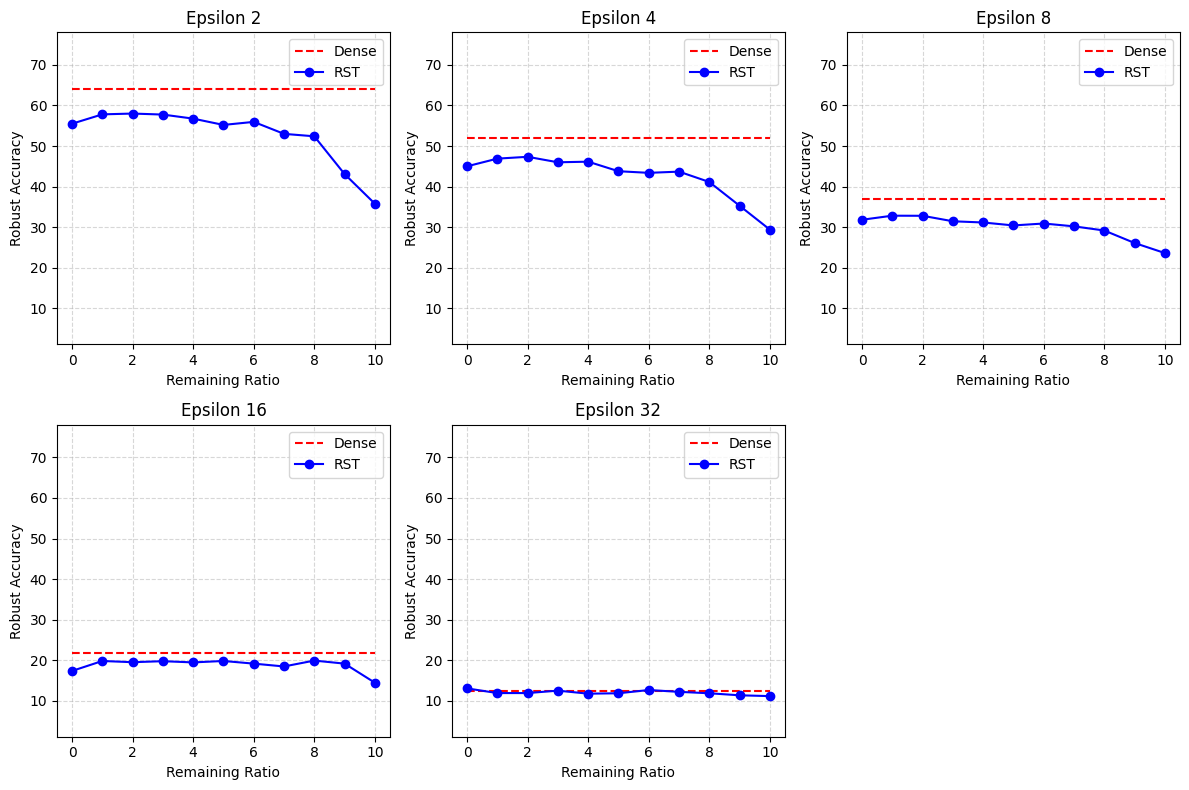

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# Sample data
epsilon_2 =  [55.50, 57.80, 58.00, 57.75, 56.75, 55.20, 55.95, 53.0, 52.4, 43.1, 35.8]
epsilon_4 =  [45.01, 46.90, 47.35, 46.00, 46.15, 43.80, 43.4, 43.7, 41.15, 35.3, 29.42]
epsilon_8 =  [31.85, 32.85, 32.825, 31.475, 31.175, 30.45, 30.925, 30.225, 29.2, 26.125, 23.65]
epsilon_16 = [17.40, 19.85, 19.55, 19.80, 19.50, 19.85, 19.20, 18.5, 19.95, 19.2, 14.5]
epsilon_32 = [13.10, 11.95, 11.95, 12.55, 11.80, 11.90, 12.7, 12.25, 11.9, 11.4, 11.2]

baseline_values = [63.95, 52.00, 36.9, 21.8, 12.55] 

data_sets = [epsilon_2, epsilon_4, epsilon_8, epsilon_16, epsilon_32]

# Create 2x3 grid of plots (for 5 graphs)
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

y_min = min(min(data) for data in data_sets) - 10
y_max = max(max(data) for data in data_sets) + 20

for ax, data, baseline, title in zip(axes.flat, data_sets, baseline_values, 
                                     ['Epsilon 2', 'Epsilon 4', 'Epsilon 8', 'Epsilon 16', 'Epsilon 32']):
    ax.plot(np.arange(11), [baseline] * 11, linestyle='--', label='Dense', color='red')
    ax.plot(np.arange(11), data, linestyle='-', marker='o', label='RST', color='blue')
    ax.legend()
    ax.set_title(title)
    ax.set_xlabel('Remaining Ratio')
    ax.set_ylabel('Robust Accuracy')
    ax.set_ylim(y_min, y_max)
    ax.grid(True, linestyle='--', alpha=0.5)  # Improved visibility with grid lines

# Hide empty subplot in 2x3 grid
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

## Natural Accuracy with different Perturbation

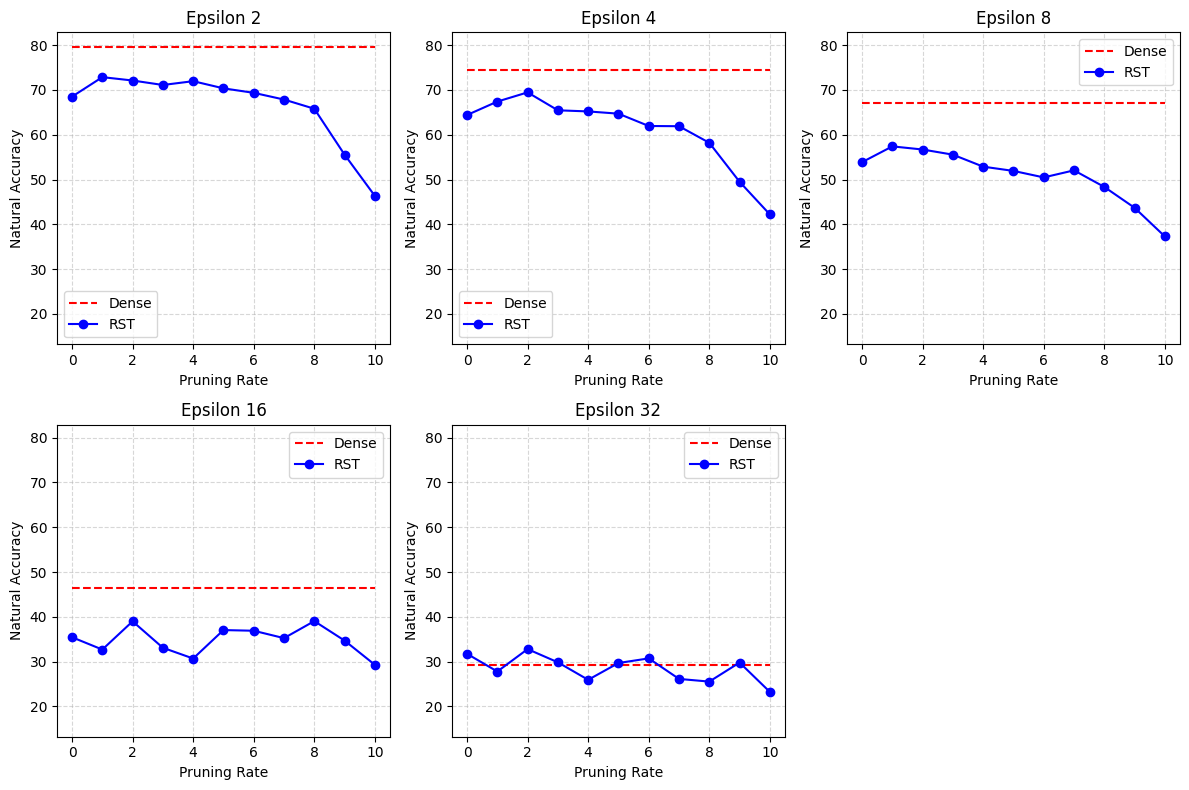

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
epsilon_2 =  [68.5, 72.85, 72.1, 71.1, 71.95, 70.35, 69.35, 67.85, 65.8, 55.55, 46.35]
epsilon_4 =  [64.4, 67.4, 69.45, 65.45, 65.2, 64.7, 61.95, 61.9, 58.2, 49.5, 42.21]
epsilon_8 =  [53.875, 57.4, 56.7, 55.55, 52.875, 51.925, 50.475, 52.05, 48.35, 43.7, 37.3]
epsilon_16 = [35.45, 32.7, 39.0, 33.1, 30.7, 37.05, 36.9, 35.25, 39.05, 34.7, 29.3]
epsilon_32 = [31.75, 27.8, 32.8, 29.85, 25.95, 29.7, 30.73, 26.15, 25.55, 29.8, 23.25]

baseline_values = [79.55, 74.5, 67.1, 46.4, 29.15] 

data_sets = [epsilon_2, epsilon_4, epsilon_8, epsilon_16, epsilon_32]

# Create 2x3 grid of plots (for 5 graphs)
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

y_min = min(min(data) for data in data_sets) - 10
y_max = max(max(data) for data in data_sets) + 10

for ax, data, baseline, title in zip(axes.flat, data_sets, baseline_values, 
                                     ['Epsilon 2', 'Epsilon 4', 'Epsilon 8', 'Epsilon 16', 'Epsilon 32']):
    ax.plot(np.arange(11), [baseline] * 11, linestyle='--', label='Dense', color='red')
    ax.plot(np.arange(11), data, linestyle='-', marker='o', label='RST', color='blue')
    ax.legend()
    ax.set_title(title)
    ax.set_xlabel('Pruning Rate')
    ax.set_ylabel('Natural Accuracy')
    ax.set_ylim(y_min, y_max)
    ax.grid(True, linestyle='--', alpha=0.5)  # Improved visibility with grid lines
    
# Hide empty subplot in 2x3 grid
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

## Train 20% and Test 100%

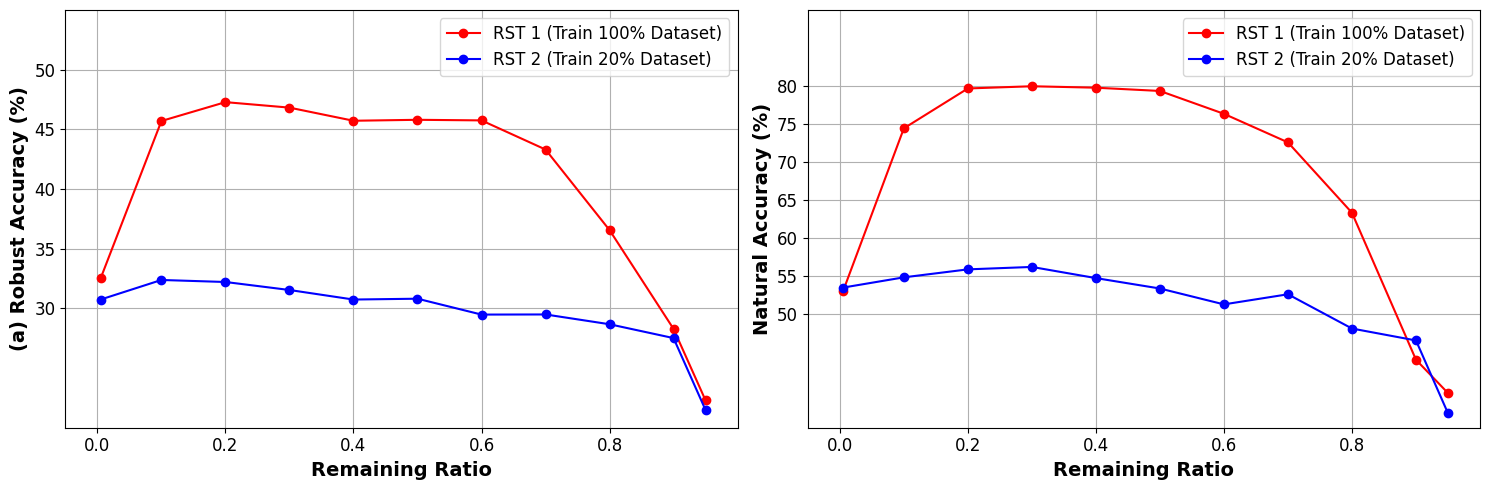

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Define data for the plot
remaining_ratio = [0.005, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
robust_acc1 = [32.51, 45.7, 47.28, 46.82, 45.72, 45.8, 45.75, 43.31, 36.56, 28.28, 22.29]
natural_acc1 = [52.98, 74.42, 79.67, 79.96, 79.77, 79.34, 76.33, 72.57, 63.3, 43.95, 39.56]

robust_acc2 = [30.74, 32.38, 32.21, 31.54, 30.74, 30.81, 29.48, 29.49, 28.67, 27.51, 21.48]
natural_acc2 = [53.45, 54.8, 55.85, 56.17, 54.7, 53.33, 51.24, 52.57, 48.06, 46.49, 36.9]

# Create the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Robust Accuracy
ax1.plot(remaining_ratio, robust_acc1, 'r-o', label='RST 1 (Train 100% Dataset)')
ax1.plot(remaining_ratio, robust_acc2, 'b-o', label='RST 2 (Train 20% Dataset)')
# ax1.set_title("(a) Robust Acc @ CIFAR-10", fontsize=16, fontweight='bold')
ax1.set_xlabel("Remaining Ratio", fontsize=14, fontweight='bold')
ax1.set_ylabel("(a) Robust Accuracy (%)", fontsize=14, fontweight='bold')
ax1.set_xlim(-0.05, 1)
ax1.set_ylim(20, 55)
ax1.grid(True)
ax1.legend(fontsize=12)
ax1.set_yticks(np.arange(30, 51, 5))
ax1.set_xticks(np.arange(0, 1, 0.2))
ax1.tick_params(axis='both', which='major', labelsize=12)

# Plot Natural Accuracy
ax2.plot(remaining_ratio, natural_acc1, 'r-o', label='RST 1 (Train 100% Dataset)')
ax2.plot(remaining_ratio, natural_acc2, 'b-o', label='RST 2 (Train 20% Dataset)')
# ax2.set_title("(b) Natural Acc @ CIFAR-10", fontsize=16, fontweight='bold')
ax2.set_xlabel("Remaining Ratio", fontsize=14, fontweight='bold')
ax2.set_ylabel("Natural Accuracy (%)", fontsize=14, fontweight='bold')
ax2.set_xlim(-0.05, 1)
ax2.set_ylim(35, 90)
ax2.grid(True)
ax2.legend(fontsize=12)
ax2.set_yticks(np.arange(50, 85, 5))
ax2.set_xticks(np.arange(0, 1, 0.2))
ax2.tick_params(axis='both', which='major', labelsize=12)

# Show the plot
plt.tight_layout()
plt.show()


## Re-train RST

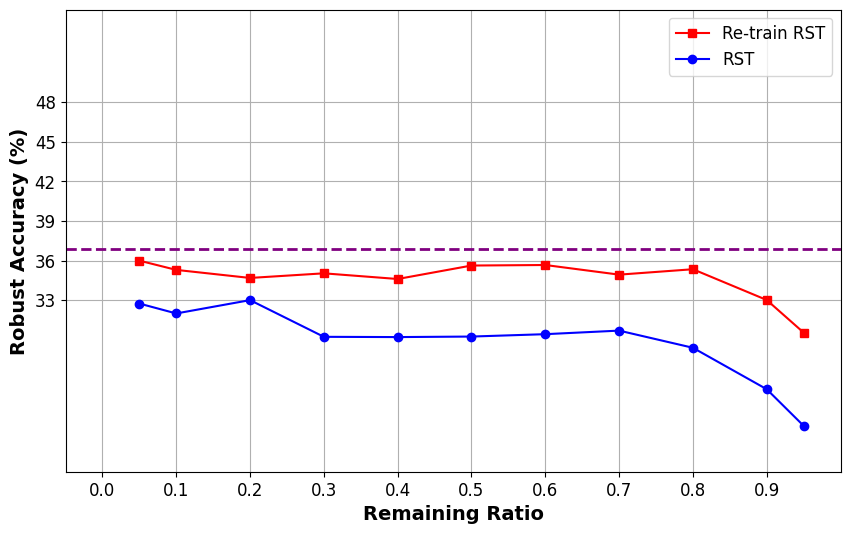

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
remaining_ratio = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
rst = [32.74, 31.99, 33.0, 30.22, 30.2, 30.24, 30.42, 30.69, 29.39, 26.25, 23.48]
retrain_rst = [35.99, 35.29, 34.68, 35.03, 34.6, 35.62, 35.66, 34.93, 35.34, 33.01, 30.54]

# Create the plot with different initialization methods
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Robust Accuracy for different initialization methods
ax.plot(remaining_ratio, retrain_rst, marker='s', linestyle='-', color='red', label='Re-train RST')
ax.plot(remaining_ratio, rst, marker='o', linestyle='-', color='blue', label='RST')
ax.axhline(y=36.9, color='purple', linestyle='--', linewidth=2)

# ax.set_title("Resnet @ CIFAR-10", fontsize=16, fontweight='bold')
ax.set_xlabel("Remaining Ratio", fontsize=14, fontweight='bold')
ax.set_ylabel("Robust Accuracy (%)", fontsize=14, fontweight='bold')
ax.set_xlim(-0.05, 1)
ax.set_ylim(20, 55)
ax.grid(True)
ax.legend(fontsize=12)
ax.set_yticks(np.arange(33, 51, 3))
ax.set_xticks(np.arange(0, 1, 0.1))

ax.tick_params(axis='both', which='major', labelsize=12)